In [2]:
#IMPORTING PACKAGES AND SETTING PATHS 

import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from matplotlib import style
from scipy.stats.mstats import winsorize
from scipy import stats 
import warnings
import time
from pandas_datareader import data as wb
from scipy.stats import spearmanr
import wrds as wrds
from matplotlib.ticker import FuncFormatter
db = wrds.Connection(wrds_username='kirillstepanov')
warnings.filterwarnings('ignore')

path2as1 = Path('C:/Users/JasperGamin/Desktop/UNI/Quant Trading/zData2022')
path2as2 = Path('C:/Users/JasperGamin/Desktop/UNI/Quant Trading/zData2022')
path2as3 = Path('/Users/leftstories/Documents/My_Docs/FS_Study_Material/Quant Trading/Assignment 3')
path     = Path('C:/Users/JasperGamin/Desktop/UNI/Quant Trading/zData2022')
h5_path  = path2as3 / 'asgnmt_3v4.h5'

Loading library list...
Done


SECTION 1: DEFINING GENERAL FUNCTIONS

In [3]:
#DEFINING FUNCTIONS

def hdf(df, key, filename = 'asgnmt_3v4.h5', data_columns = True, complib = 'zlib', path = path2as3, mode = 'a'):
    """
    df = DataFrame to save to hdf 
    path = Path from pathlib (from pathlib import Path)
    key = key to save the df within the df

    Saves the DF in the specified path with the keys specified

    """
    df.to_hdf(path / filename , key = key, mode = mode, data_columns = data_columns, complib = complib)
    print('The dataframe was saved to HDF under the key: ' + key + ' within the ' + filename)

def maximum_absolute_scaling(df, columns):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df_scaled[column ] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df, columns):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())      
    return df_norm

# Apply the Z-score absolute scaling in Pandas using the .abs() and .max() methods
def z_score_scaling(df, columns):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df_scaled[column] = (df_scaled[column] - df_scaled[column].mean())  / df_scaled[column].abs().max()
    return df_scaled 

def rolling_regression(df, groupby, window, exog_vars, endog, monthly_basis): 
    """"
    
    function applies rolling regression to a df via grouping

    df = df to apply the regression to, should contain index in numbers and both the exogeneous and endogenuous variables: DATAFRAME
    groupby = list of columns by which the df should be grouped initially, first PERMNO and second DATE: LIST
    window = rolling window : INT
    exog_vars = exogenuous variables: LIST
    endog = endogenous variables: LIST
    monthly_basis = whether the merged df only has the betas of the first day of the month for each, say, stock; FALSE = DAILY PARAMS RETURNED: BOOLEAN

    returns a DF with values grouped by PERMNO or SECID or similiar and date

    """
    betas = pd.DataFrame()
    initial_col = list(df.columns)
    df1 = df
    df = df.set_index(groupby).sort_index() #DONE TO MERGE THE REGRESSION OUTPUT BY THE GROUP BY VARIABLE AND THE DATE 
    df_grouped = df.groupby(groupby[0]).filter(lambda x: len(x) > window).groupby(groupby[0])

    for name,group in df_grouped: 
        exog = sm.add_constant(df_grouped.get_group(name)[exog_vars]).sort_index()
        endog = df_grouped.get_group(name)['excret'].sort_index()       
        rols = RollingOLS(endog, exog, window = window)
        rres = rols.fit()
        params = rres.params
        betas = betas.append(params)
        
    betas = betas.rename(columns=lambda x: x + 'beta')
    betas_col = list(betas.columns)
    daily_data = pd.merge(df, betas, left_index=True, right_index = True)

    if monthly_basis: 
        daily_data[groupby[0]] = daily_data.index.get_level_values(0)
        daily_data[groupby[1]] = daily_data.index.get_level_values(1)
        daily_data.reset_index(inplace=True, drop = True)
        daily_data['month_year'] = daily_data[groupby[1]].dt.to_period('M')
        datax = daily_data.groupby(by = [groupby[0], 'month_year']).first()
        datay = pd.merge_ordered(df1, datax, on = initial_col)
        data_f = pd.merge(df1, datay[betas_col + groupby].groupby(groupby[0]).apply(lambda x: x.fillna(method = 'ffill')), on = groupby).reset_index()
        return data_f   
    else: 
        return daily_data

def winsorization(df, vars2win, limit): 
    for z in vars2win: 
        goods = df[z].notna()
        df.loc[goods,z] = winsorize(df.loc[goods, z], limits = limit).data
    return df

def normalisation(df, vars2norm, constant): 
    for var in vars2norm:
        var_norm, lambda_ = stats.boxcox(df[var] + constant)
        df.loc[:,var] = var_norm
    return df

def gr_winsor_roll(gr, vars2wins):
    gr = gr.reset_index(drop = True)
    for z in vars2wins:
        for idx in range(252, len(gr)):
           gr.loc[idx-252:idx, z] =  winsorize(gr.loc[idx-252:idx, z], limits = 0.001, inplace = True).data
        return gr

def winsor_roll(df, vars2wins):
    for z in var2wins: 
        for idx in range(252):
            df.loc[idx-252:idx, z] = winsorize(gr.loc[idx-252:idx,z], limits = 0.001, inplace = True).data
        return df

def import_stock_data(tickers, start = '1999-01-01', end = '2020-12-31'):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start, end = end)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start, end = end)['Adj Close']
    return(data)

def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

SECTION 2: PREPARING THE DATA SET

In [4]:
#IMPORTING DATA FROM THE ASSIGNMENTS
dataall     = pd.read_hdf(path2as3 / 'asgnmt_3v3.h5', key = 'dataall') 
permno_50   = pd.read_hdf(path2as3 / 'asgnmt_3v3.h5', key = 'permno_50') 
glb         = pd.read_hdf(path2as3 / 'asgnmt_3v3.h5', key = 'glb')
mfiv        = pd.read_hdf(path2as3 / 'asgnmt_3v3.h5', key = 'mfiv')
mfis        = pd.read_hdf(path2as3 / 'asgnmt_3v3.h5', key = 'mfis')

#RENAMING COLUMNS AND SETTING DATE AS DATETIME 
mfiv            = mfiv.rename(columns = {'id':'permno'})
mfiv.date       = pd.to_datetime(mfiv.date)
glb             = glb.rename(columns  = {'id':'permno'})
glb.date        = pd.to_datetime(glb.date)
mfis            = mfis.rename(columns = {'id':'permno'})
mfis.date       = pd.to_datetime(mfis.date)
dataall.date    = pd.to_datetime(dataall.date)

hdf(mfiv, key = 'mfiv')
hdf(glb, key = 'glb')
hdf(mfis, key = 'mfis')
hdf(dataall, key = 'dataall')
hdf(permno_50, key = 'permno_50')

In [5]:
#MERGING DATA 
data = pd.merge(dataall, permno_50, on = ['permno', 'permno'])
data = pd.merge(data, mfis,         on = ['permno', 'date'])
data = pd.merge(data, mfiv,         on = ['permno', 'date'])
data = pd.merge(data, glb,          on = ['permno', 'date'])
data = data.sort_values(['permno', 'date']).reset_index(drop = True)

In [6]:
#CONNECTING TO QUANDL AND GETTING SHILLER CAPE 10 MONTHLY DATA, MERGING WITH DATA DF
import quandl 
quandl.ApiConfig.api_key = "" 
cape10                   = quandl.get('MULTPL/SHILLER_PE_RATIO_MONTH', start_date = '1999-01-01', end_date = '2020-12-01' )
cape10                   = cape10.reset_index().rename(columns={'Date':'date', 'Value' : 'cape10'})
cape10['cape10'] = cape10['cape10'].pct_change()
winsorization(cape10, ['cape10'], limit = 0.0001)
#normalisation(cape10, ['cape10'], 1)

,date,cape10
0,1999-01-01,NaN
1,1999-02-01,-0.004190
2,1999-03-01,0.023515
3,1999-04-01,0.032648
4,1999-05-01,-0.003513
...,...,...
270,2020-09-30,0.001621
271,2020-10-01,0.012625
272,2020-11-01,0.038043
273,2020-11-30,0.018787


In [7]:
#MERGING CAPE 10 AND DATA ON MONTHLY BASIS
cape10['month']     = cape10['date'].dt.to_period('M')
data['month']       = data['date'].dt.to_period('M')
data                = pd.merge(data, cape10, on = ['month'], how = 'inner').drop(['month', 'date_y', 'sp500', 'mktcapL'], axis = 1).rename(columns = {'date_x': 'date'}).drop_duplicates(['date', 'secid', 'skew', 'iv', 'permno', 'ret', 'prc', 'shrout',
                    'mktrf', 'smb', 'hml', 'mom', 'rf', 'excret', 'mfis30', 'mfis91',
                    'mfis182', 'mfis273', 'mfis365', 'mfiv30', 'mfiv91', 'mfiv182',
                    'mfiv273', 'mfiv365', 'glb2_D30', 'glb3_D30', 'glb2_D91', 'glb3_D91',
                    'glb2_D182', 'glb3_D182', 'glb2_D273', 'glb3_D273', 'glb2_D365',
                    'glb3_D365']).reset_index(drop = True)


In [8]:
#IMPORTING TREASURY YIELD CURVE AND MERGING WITH THE DATASET 
importrates          = quandl.get("USTREASURY/YIELD", start_date = '1999-01-01', end_date = '2020-12-31') #Importing data for the last year, assuming 252 trading days
tyields              = importrates.drop(['1 MO', '2 MO', '3 MO', '6 MO', '1 YR', '3 YR', '5 YR', '7 YR', '20 YR', '30 YR'], axis=1)/100
tyields['t10yminus2y'] = tyields['10 YR'] - tyields['2 YR']
winsorization(tyields, ['t10yminus2y'], limit = 0.0001)
#normalisation(tyields, ['t10yminus2y'], 1)
tyields['t10yminus2y'] = tyields['t10yminus2y'].fillna(method = 'ffill')
tyields              = tyields.reset_index().drop(['2 YR', '10 YR'], axis = 1).rename(columns = {'Date':'date'})
tyields.date         = pd.to_datetime(tyields.date)
data                 = pd.merge(data, tyields, on = ['date', 'date'], how = 'left').reset_index(drop = True)


In [9]:
#IMPORTING THE MISSING FF FACTORS AND MERGING WITH DATA
import pandas_datareader as web

startdt = datetime.datetime(1999,1,1)

d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt)
d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt)
d3 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench',start=startdt)

ff = d1[0]/100
ff = ff.join(d2[0]/100, how = 'outer')
ff5 = d3[0]/100
ff = ff.join(ff5.loc[:,['RMW','CMA']], how = 'outer')

ff.columns = [z.lower().strip() for z in ff.columns]
ff.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

ff = ff.loc[:,['rmw', 'cma']]
ff = ff.reset_index()
ff = ff.rename(columns={'Date': 'date'})

data = pd.merge(data, ff, on = ['date', 'date'], how = 'left')


In [10]:
#ADDITIONAL FRED DATA 
from fredapi import Fred
fred = Fred(api_key='')

mortgage30us  = fred.get_series('MORTGAGE30US', observation_start = pd.to_datetime('1999-01-01'), observation_end = pd.to_datetime('2020-12-31'))/100
y10inflation = fred.get_series('T10YIE', observation_start = pd.to_datetime('1999-01-01'), observation_end = pd.to_datetime('2020-12-31'))/100
cpiallus  = fred.get_series('CPALTT01USM657N', observation_start = pd.to_datetime('1999-01-01'), observation_end = pd.to_datetime('2020-12-31'))
goldetfvola = fred.get_series('GVZCLS', observation_start = pd.to_datetime('1999-01-01'), observation_end = pd.to_datetime('2020-12-31'))
highyspr = fred.get_series('BAMLH0A0HYM2', observation_start = pd.to_datetime('1999-01-01'), observation_end = pd.to_datetime('2020-12-31'))/100
wtiefvola = fred.get_series('OVXCLS', observation_end = pd.to_datetime('2020-12-31'))
t10yminus3m = fred.get_series('T10Y3M', observation_start = pd.to_datetime('1999-01-01'), observation_end = pd.to_datetime('2020-12-31'))/100

data = data.set_index('date')

freddy = pd.DataFrame(index = data.index.unique())
freddy['mortgage30us'] = mortgage30us.pct_change()
freddy['mortgage30us'] = freddy['mortgage30us'].fillna(method = 'ffill')
freddy['y10inflation'] = y10inflation.pct_change()
freddy['goldetfvola']  = goldetfvola.pct_change()
freddy['highyspread']  = highyspr.pct_change()
freddy['wtiefvola']    = wtiefvola.pct_change()
freddy['t10yminus3m']  = t10yminus3m
winsorization(freddy, freddy.columns, limit = 0.0001)
#normalisation(freddy, freddy.columns, 1)
data = pd.merge(data, freddy, left_index = True, right_index = True, how = 'left')


In [11]:
#IMPORTING DOLLAR INDEX FROM YAHOO

dollar_index           = import_stock_data(tickers = 'DX-Y.NYB').reset_index()
dollar_index['date']   = pd.to_datetime(dollar_index.Date)
dollar_index           = dollar_index.rename(columns={'DX-Y.NYB': 'usdidx'})
dollar_index['usdidx'] = dollar_index['usdidx'].pct_change()
winsorization(dollar_index, ['usdidx'], limit = 0.0001)
#normalisation(dollar_index, ['usdidx'], 1)
data                   = pd.merge(data, dollar_index, on = ['date'], how = 'left').reset_index(drop = True)
data = data.drop(columns='Date')
data = data.sort_values(['permno', 'date'])

In [12]:
#CREATING LAGGED RETURNS AND INDIVIDUAL STOCK MOMENTUM 
ret_pivot = data.pivot(index = 'date', columns = 'permno', values = 'prc') #PIVOT TABLES WITH RETURNS 

lag_returns = pd.DataFrame()

lags = [1, 5, 10, 15, 20, 40, 60]
for lag in lags:
    lag_returns[f'return_{lag}d'] = (ret_pivot
                           .pct_change(lag)
                           .stack()
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
lag_returns = lag_returns.swaplevel()

mom = [5, 10, 15, 20, 40, 60]
for lag in mom:
    lag_returns[f'momentum_{lag}d'] = lag_returns[f'return_{lag}d'].sub(lag_returns.return_1d)

#MERGING DATA AND LAG RETURNS, MOMENTUM
data = pd.merge(data, lag_returns, on = ['date', 'permno'], how = 'left').sort_values(['permno', 'date'])
data = data.sort_values(['permno', 'date']).reset_index(drop = True)

In [13]:
from talib import RSI, BBANDS, MACD, ATR
#RSI
data['rsi'] = data.groupby(by='permno').prc.apply(RSI)

In [14]:
#BOLLINGER BANDS 
def compute_bb(prc):
    high, mid, low = BBANDS(prc, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=prc.index)

data = (data.join(data.groupby(by='permno').prc.apply(compute_bb)))
data['bb_high'] = data.bb_high.sub(data.prc).div(data.bb_high).apply(np.log1p)
data['bb_low'] = data.prc.sub(data.bb_low).div(data.prc).apply(np.log1p)

na_bb = data['bb_low'].isna()
data.loc[na_bb, 'bb_low'] = data['bb_low'].mean()

In [15]:
#Compute Moving Average Convergence/Divergence
def compute_macd(prc):
    macd = MACD(prc)[0]
    return (macd - np.mean(macd))/np.std(macd)
data['macd'] = (data.groupby('permno').prc.apply(compute_macd))

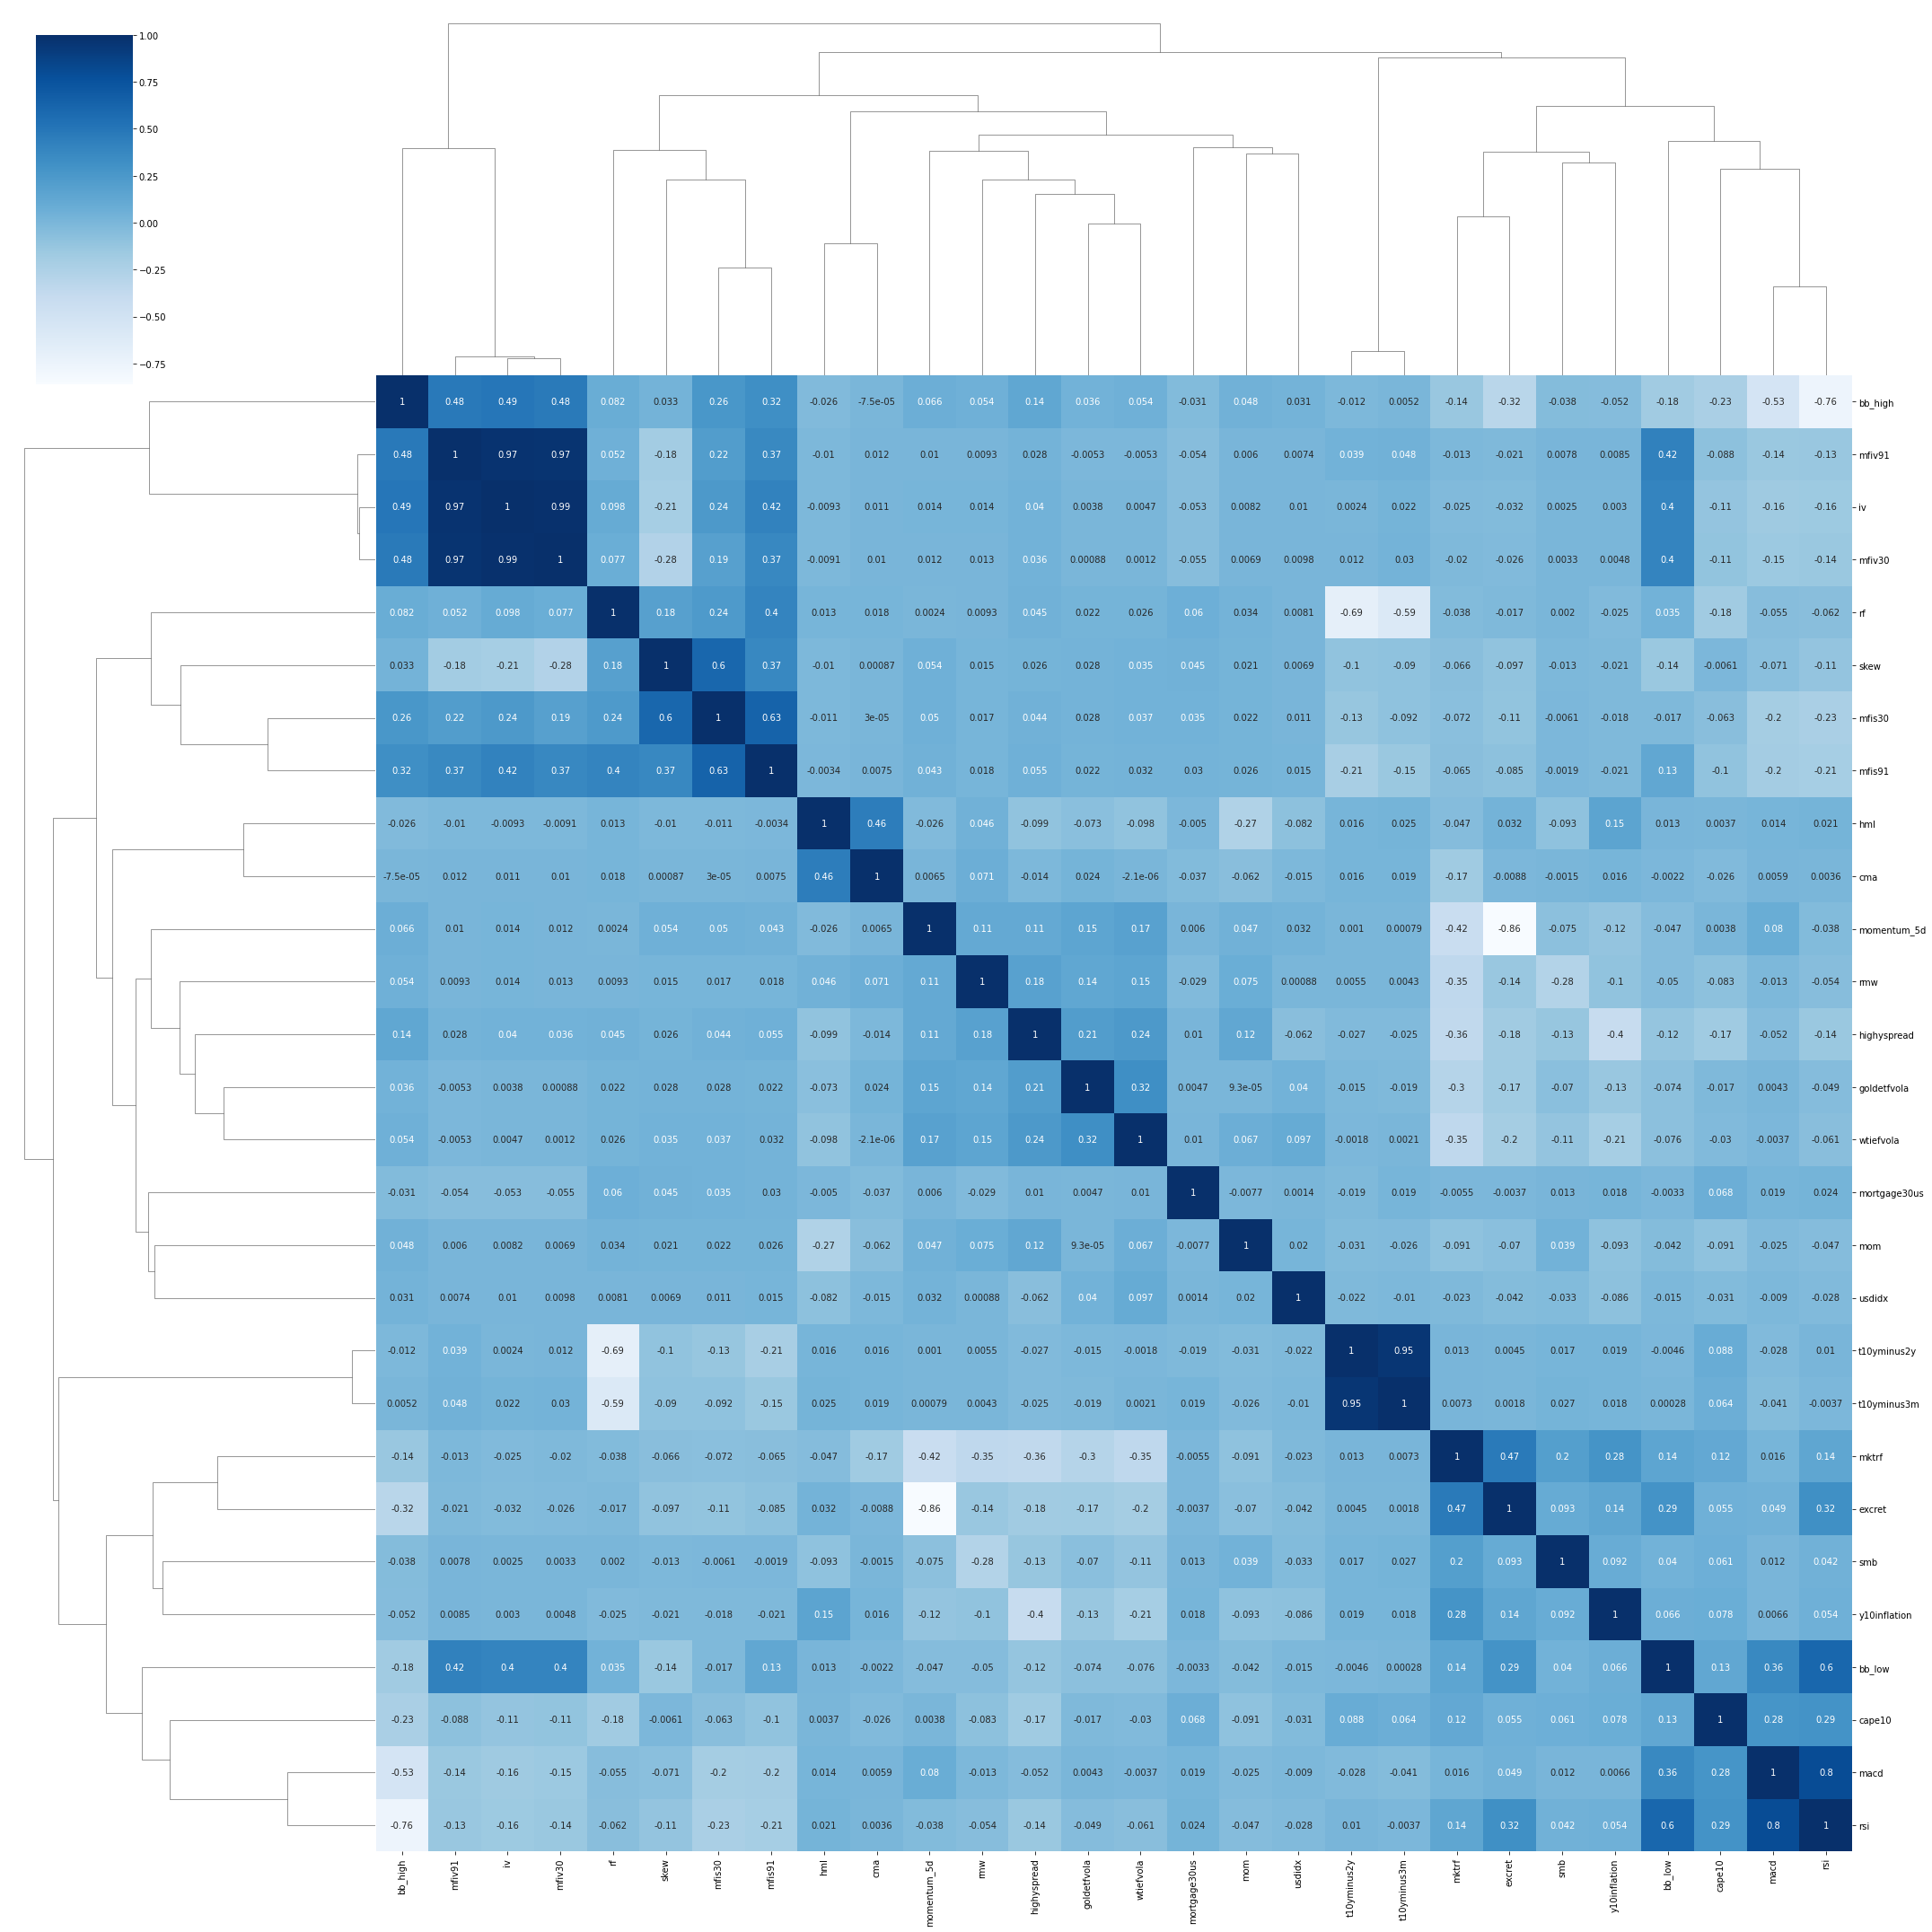

In [16]:
#PLOTTING CORRELATION
sns.clustermap(data[['skew', 'iv', 'mktrf', 'smb', 'hml', 'mom', 'rf', 'excret', 'mfis30', 'mfis91', 'mfiv30', 'mfiv91','cape10', 't10yminus2y', 'rmw', 'cma', 'mortgage30us',
       'y10inflation', 'goldetfvola', 'highyspread', 'wtiefvola','t10yminus3m', 'usdidx', 'momentum_5d', 'bb_high', 'bb_low', 'macd', 'rsi']].corr('spearman'), annot=True, cmap='Blues', figsize=(30, 30),);

In [17]:
#CREATING EXCESS GLB OVER MARKET (SPX)
spx_glb = glb.loc[glb.permno == 99991,:].loc[glb.date < '2021-01-01'].loc[glb.date > '1999-12-30'].reset_index(drop = True).set_index(['permno', 'date'])
exc_glb = pd.merge(data, spx_glb, on = 'date', how = 'left')
exc_glb[['glb2_D30_exc', 'glb3_D30_exc', 'glb2_D91_exc', 'glb3_D91_exc', 'glb2_D182_exc', 'glb3_D182_exc', 'glb2_D273_exc', 'glb3_D273_exc', 'glb2_D365_exc', 'glb3_D365_exc']] = exc_glb[['glb2_D30_x', 'glb3_D30_x', 'glb2_D91_x', 'glb3_D91_x', 'glb2_D182_x',
       'glb3_D182_x', 'glb2_D273_x', 'glb3_D273_x', 'glb2_D365_x', 'glb3_D365_x']].values - exc_glb[['glb2_D30_y', 'glb3_D30_y', 'glb2_D91_y', 'glb3_D91_y', 'glb2_D182_y',
       'glb3_D182_y', 'glb2_D273_y', 'glb3_D273_y', 'glb2_D365_y', 'glb3_D365_y']].values
data = pd.merge(data.reset_index(), exc_glb[['glb2_D30_exc', 'glb3_D30_exc', 'glb2_D91_exc', 'glb3_D91_exc', 'glb2_D182_exc', 'glb3_D182_exc', 'glb2_D273_exc', 'glb3_D273_exc', 'glb2_D365_exc', 'glb3_D365_exc']].reset_index(drop = True), left_index=True, right_index = True)
data = data.drop(columns=['index'])

In [18]:
#CREATING VALUE WEIGHTS AND BENCHMARK RETURNS 
data.loc[:,'mktcap'] = abs(data['prc'])*data['shrout']/1e6
data.loc[:,'mktcapL'] = data.groupby(['permno'])['mktcap'].shift(1)
data.loc[:,'vw'] = data.groupby(['date'])['mktcapL'].apply(lambda x: x/sum(x)).replace(np.nan,0)
vw_benchmark = data.pivot(index = 'date', columns = 'permno', values = 'vw').replace(np.NaN, 0.0)
ret = data.pivot(index = 'date', columns = 'permno', values = 'ret').replace(np.NaN, 0.0)
bench_ret = pd.DataFrame((vw_benchmark * ret).sum(axis = 1), columns = ['bench_ret'])
data = pd.merge(data, bench_ret, on = ['date']).sort_values(['permno', 'date']).reset_index(drop = True)
data = data.sort_values(['permno', 'date']).reset_index(drop = True)

In [19]:
#CALCULATING THE MARKET S&P RETURN
vw_sp500 = dataall.pivot(index = 'date', columns = 'permno', values = 'sp500').replace(np.NaN, 0.0)
ret_sp500 = dataall.pivot(index = 'date', columns = 'permno', values = 'ret').replace(np.NaN, 0.0)
mkt_ret = pd.DataFrame((vw_sp500 * ret_sp500).sum(axis = 1), columns = ['sp500return'])

#MERGING DATA AND MKTRET TO ESTIMATE THE EXCESS MARKET RETURN
data = pd.merge(data, mkt_ret, on = ['date']).sort_values(['permno', 'date']).reset_index(drop = True)

In [20]:
#CALCULATING THE EXCESS RETURN OF A STOCK AND RUNNING THE ROLLING REGRESSION TO ESTIMATE THE STOCKS' FACTOR BETAS 
data['excret'] = data['ret'] - data['sp500return']

In [21]:
#CREATING FORWARD RETURN VARIABLES 
#STOCK FORWARD
data.sort_values(by = ['permno','date'], inplace = True)
data.loc[:,'fret1d'] = data.groupby(['permno'])['ret'].shift(-1)
#MARKET FORWARD
data['sp500return_fwd'] = data.groupby(['permno'])['sp500return'].shift(-1)
#MARKET EXCESS FORWARD
data['ex_fwd_ret'] = data['fret1d'] - data['sp500return_fwd']
data = data.dropna(subset = ['ex_fwd_ret'])
data = data.sort_values(['permno', 'date']).reset_index(drop = True)

In [22]:
data = data.loc[data.date > '2008-12-28'].reset_index(drop = True) #TAKING DATA FROM 2009 AS WE NEED NOT HAVE BETAS FOR EARLIER DATES 

SECTION 3: FACTOR BETAS ESTIMATION

In [23]:
#ROLLING REGRESSION FOR BETA ESTIMATION

betas = ['cape10', 't10yminus2y', 'rmw', 'cma', 'mortgage30us', 'y10inflation', 'goldetfvola', 'highyspread', 'wtiefvola','t10yminus3m', 'usdidx','mktrf', 'smb', 'hml', 'mom']
endog = ['excret']
groupby = ['permno', 'date']
winsorization(data, ['excret'], limit = 0.0001)
#normalisation(data, ['excret'], 1)
data = rolling_regression(df = data, groupby = groupby, window = 252, endog = endog, exog_vars = betas, monthly_basis = False)
data = data.reset_index()

In [24]:
#DROPPING THE 2009 N/A VALUES AFTER THE ROLLING REGRESSION
betas_names = ['cape10beta', 't10yminus2ybeta','rmwbeta',
               'cmabeta','mortgage30usbeta','y10inflationbeta',
               'goldetfvolabeta','highyspreadbeta','wtiefvolabeta',
               't10yminus3mbeta','usdidxbeta','mktrfbeta','smbbeta',
               'hmlbeta','mombeta']
data = data.dropna(subset = betas_names)
data = data.reset_index(drop = True)

In [25]:
#CREATING PIVOTS TO USE FOR FURTHER PORTFOLIO OPTIMIZATION
mktrfbeta = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'mktrfbeta')
rmwbeta   = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'rmwbeta')
mombeta   = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'mombeta')
smbbeta   = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'smbbeta')
hmlbeta   = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'hmlbeta')
cmabeta   = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'cmabeta')
exc_ret   = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'excret')
ret       = data.loc[data.date >='2010'].pivot(index = 'date', columns = 'permno', values = 'ret')
bench_ret = vw_benchmark * ret
bench_ret = bench_ret.loc[bench_ret.index >='2010']

In [26]:
#SAVING NECESSARY DATA INTO HDF FOR FURTHER USE IN PORTFOLIO OPTIMIZATION
hdf(vw_benchmark, key = 'vw_benchmark')
hdf(mktrfbeta, key    = 'mktrfbeta')
hdf(rmwbeta, key      = 'rmwbeta')
hdf(mombeta, key      = 'mombeta')
hdf(smbbeta, key      = 'smbbeta')
hdf(hmlbeta, key      = 'hmlbeta')
hdf(cmabeta, key      = 'cmabeta')
hdf(exc_ret, key      = 'excret')
hdf(ret,     key      = 'ret')
hdf(bench_ret, key    = 'bench_ret')

The dataframe was saved to HDF under the key: vw_benchmark within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: mktrfbeta within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: rmwbeta within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: mombeta within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: smbbeta within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: hmlbeta within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: cmabeta within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: excret within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: ret within the asgnmt_3v4.h5
The dataframe was saved to HDF under the key: bench_ret within the asgnmt_3v4.h5


SECTION 4: TESTING REGRESSIONS FOR EXCESS STOCK RETURN PREDOCTION

In [27]:
#PREDICTORS 
exog_vars = ['glb3_D30_exc', 'glb3_D91_exc', 'momentum_5d', 'mfis30','cape10beta', 
            't10yminus2ybeta','rmwbeta','cmabeta','mortgage30usbeta','y10inflationbeta',
            'goldetfvolabeta','highyspreadbeta','wtiefvolabeta','t10yminus3mbeta','usdidxbeta',
            'mktrfbeta','smbbeta','hmlbeta','mombeta', 'skew', 'iv', 'momentum_60d', 'bb_high', 'bb_low', 'rsi', 'macd']

In [28]:
#LINEAR REGRESSION
from sklearn.linear_model import LinearRegression

predictions = pd.DataFrame(index = data.index)

lr = LinearRegression(normalize=False, copy_X = True)
exog = data[exog_vars]
endog = data['ex_fwd_ret']
lr.fit(X = exog, y = endog)
y_pred = lr.predict(data[exog_vars])
predictions['pred_ex_fwd_1d_lr'] = y_pred

lr_r2 = lr.score(data[exog_vars], data['ex_fwd_ret'])
lr_r, lr_p = spearmanr(data['ex_fwd_ret'], predictions['pred_ex_fwd_1d_lr'])
print(f'Information Coefficient Linear Regression 1d (overall): {lr_r:.6%} (p-value: {lr_p:.6%}), (R-squared): {lr_r2:.6%}')


Information Coefficient Linear Regression 1d (overall): 1.485466% (p-value: 0.000004%), (R-squared): 0.135933%


In [29]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['ex_fwd_ret'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['ex_fwd_ret'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

predictors = exog_vars

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-14, 1e-13, 1e-12,1e-11, 1e-10,1e-9, 1e-8, 1e-7, 1e-6, 1e-5,1e-5, 1e-4,1e-3, 1, 5, 10]

#Initialize the dataframe to store coefficients
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=['rss', 'intercept'] + predictors)

#Iterate over the 10 alpha values:
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i])

In [30]:
coef_matrix_lasso

,rss,intercept,glb3_D30_exc,glb3_D91_exc,momentum_5d,mfis30,cape10beta,t10yminus2ybeta,rmwbeta,cmabeta,...,smbbeta,hmlbeta,mombeta,skew,iv,momentum_60d,bb_high,bb_low,rsi,macd
alpha_1e-15,41.310991,-0.001355,0.003736,0.001173,-0.021931,-0.00019,-0.000831,-0.000182,0.000225,0.000007,...,0.000197,-0.000111,-0.000086,0.002929,0.002854,0.022918,-0.004498,-0.000557,0.000018,-0.000331
alpha_1e-14,41.310991,-0.001355,0.003736,0.001173,-0.021931,-0.00019,-0.000831,-0.000182,0.000225,0.000007,...,0.000197,-0.000111,-0.000086,0.002929,0.002854,0.022918,-0.004498,-0.000557,0.000018,-0.000331
alpha_1e-13,41.310991,-0.001355,0.003736,0.001173,-0.021931,-0.00019,-0.000831,-0.000182,0.000225,0.000007,...,0.000197,-0.000111,-0.000086,0.002929,0.002854,0.022917,-0.004498,-0.000557,0.000018,-0.000331
alpha_1e-12,41.310991,-0.001355,0.003736,0.001173,-0.021931,-0.00019,-0.000831,-0.000182,0.000225,0.000007,...,0.000197,-0.000111,-0.000086,0.002929,0.002854,0.022917,-0.004498,-0.000557,0.000018,-0.000331
alpha_1e-11,41.310991,-0.001355,0.003736,0.001173,-0.021927,-0.00019,-0.000831,-0.000182,0.000225,0.000007,...,0.000197,-0.000111,-0.000086,0.002929,0.002854,0.022913,-0.004498,-0.000557,0.000018,-0.000331
alpha_1e-10,41.310991,-0.001354,0.003736,0.001172,-0.021886,-0.000189,-0.00083,-0.000182,0.000225,0.000007,...,0.000197,-0.000111,-0.000086,0.002927,0.002853,0.022872,-0.004492,-0.000558,0.000018,-0.00033
alpha_1e-09,41.310994,-0.001347,0.003736,0.001156,-0.021481,-0.000187,-0.000821,-0.00018,0.000225,0.000007,...,0.000195,-0.00011,-0.000084,0.002913,0.00284,0.022462,-0.004432,-0.000571,0.000018,-0.000328
alpha_1e-08,41.311231,-0.001271,0.003735,0.000997,-0.017441,-0.00016,-0.000731,-0.00016,0.000217,0.000002,...,0.000179,-0.000106,-0.000072,0.002772,0.002711,0.018371,-0.003835,-0.0007,0.000017,-0.000302
alpha_1e-07,41.321459,-0.000492,0.003643,0.000062,-0.0,-0.0,-0.0,-0.000081,0.000141,0.0,...,0.000053,-0.000045,-0.0,0.001693,0.001615,0.0,-0.000513,-0.0,0.000005,-0.000109
alpha_1e-06,41.365963,0.000094,0.00016,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


In [31]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1e-11, max_iter = 1e5, normalize = False)        
exog = data[exog_vars]
endog = data['ex_fwd_ret']
lasso.fit(X = exog, y = endog)
y_pred = lasso.predict(data[exog_vars])
predictions['pred_ex_fwd_1d_lasso'] = y_pred

l_r2 = lasso.score(data[exog_vars], data['ex_fwd_ret'])
l_r, l_p = spearmanr(data['ex_fwd_ret'], predictions['pred_ex_fwd_1d_lasso'])
print(f'Information Coefficient Lasso Regression 1d (overall): {l_r:.6%} (p-value: {l_p:.6%}), (R-squared): {l_r2:.6%}')

Information Coefficient Lasso Regression 1d (overall): 1.485462% (p-value: 0.000004%), (R-squared): 0.135933%


In [32]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['ex_fwd_ret'])
    y_pred = ridgereg.predict(data[predictors])

    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['ex_fwd_ret'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

predictors =  exog_vars

#Set the different values of alpha to be tested
alpha_ridge = [1e-3, 5*1e-2, 3*1e-2, 1e-2, 1e-1,1e-1, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=['rss', 'intercept'] + predictors)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i])

In [33]:
coef_matrix_ridge

,rss,intercept,glb3_D30_exc,glb3_D91_exc,momentum_5d,mfis30,cape10beta,t10yminus2ybeta,rmwbeta,cmabeta,...,smbbeta,hmlbeta,mombeta,skew,iv,momentum_60d,bb_high,bb_low,rsi,macd
alpha_0.001,41.310994,-0.001352,0.003721,0.001191,-0.021368,-0.000187,-0.000828,-0.00018,0.000225,0.000007,...,0.000197,-0.000111,-0.000086,0.002914,0.002839,0.022349,-0.004413,-0.000599,0.000018,-0.000328
alpha_0.05,41.31272,-0.001115,0.003228,0.00178,-0.009305,-0.000106,-0.000721,-0.000128,0.000196,0.000013,...,0.000194,-0.000102,-0.00009,0.002377,0.002277,0.010068,-0.002491,-0.001134,0.000016,-0.000252
alpha_0.03,41.311881,-0.001214,0.003393,0.001593,-0.012158,-0.000134,-0.00076,-0.000144,0.000206,0.000011,...,0.000196,-0.000105,-0.000089,0.002565,0.002471,0.012998,-0.002975,-0.001106,0.000017,-0.000275
alpha_0.01,41.311155,-0.001314,0.003604,0.001337,-0.01734,-0.000168,-0.000805,-0.000167,0.000218,0.000009,...,0.000198,-0.000109,-0.000087,0.002793,0.00271,0.018272,-0.003797,-0.000874,0.000018,-0.000308
alpha_0.1,41.314742,-0.000913,0.002928,0.002069,-0.005771,-0.000055,-0.000644,-0.000104,0.000175,0.000016,...,0.000186,-0.000094,-0.000092,0.002021,0.00192,0.00638,-0.001815,-0.000988,0.000013,-0.000213
alpha_0.1,41.314742,-0.000913,0.002928,0.002069,-0.005771,-0.000055,-0.000644,-0.000104,0.000175,0.000016,...,0.000186,-0.000094,-0.000092,0.002021,0.00192,0.00638,-0.001815,-0.000988,0.000013,-0.000213
alpha_1,41.330567,-0.000188,0.001532,0.001984,-0.000675,0.00007,-0.000234,-0.00004,0.000067,0.00001,...,0.000119,-0.000043,-0.000072,0.000578,0.000673,0.000607,-0.000085,0.000118,0.000003,-0.000069
alpha_5,41.347379,-0.000007,0.000637,0.000946,-0.000176,0.000036,-0.000027,-0.000015,0.000014,0.000001,...,0.00006,-0.000011,-0.000033,0.000114,0.000266,0.00006,0.000179,0.000201,0.0,-0.000021
alpha_10,41.354224,0.000034,0.000383,0.000581,-0.000098,0.000021,-0.000002,-0.000009,0.000006,-0.0,...,0.000038,-0.000005,-0.00002,0.000049,0.000162,0.00002,0.000138,0.000141,0.0,-0.000012
alpha_20,41.359495,0.000061,0.000214,0.00033,-0.000053,0.000012,0.000004,-0.000005,0.000002,-0.000001,...,0.000022,-0.000002,-0.000011,0.000021,0.000091,0.000007,0.000087,0.000086,0.0,-0.000006


In [34]:
#RIDGE REGRESSION FOR THE DATA PERMNO 50 
ridge = Ridge(alpha = 0.05,max_iter = 1e5, normalize = False)
exog = data[exog_vars]
endog = data['ex_fwd_ret']
ridge.fit(X = exog, y = endog)
y_pred = ridge.predict(data[exog_vars])
predictions['pred_ex_fwd_1d_ridge'] = y_pred

r_r2 = ridge.score(data[exog_vars], data['ex_fwd_ret'])
r_r, r_p = spearmanr(data['ex_fwd_ret'], predictions['pred_ex_fwd_1d_ridge'] )
print(f'Information Coefficient Lasso Regression 1d (overall): {r_r:.6%} (p-value: {r_p:.6%}), (R-squared): {r_r2:.6%}')

Information Coefficient Lasso Regression 1d (overall): 1.483218% (p-value: 0.000005%), (R-squared): 0.135930%


SECTION 5: ROLLING REGRESSION FOR EXCESS FORWARD RETURN PREDICTIONS

In [35]:
#SETTING THE DF FOR OOS PREDICTION
df_train1 = data.loc[data.date >= '2009-12-30'].set_index(['permno', 'date'])
#DF with necessary date 
dates = pd.to_datetime(df_train1.index.get_level_values(1)).values

In [36]:
def winsorization(df, vars2win, limit): 
    for z in vars2win: 
        goods = df[z].notna()
        df.loc[goods,z] = winsorize(df.loc[goods, z], limits = limit).data

In [36]:
winsorization(df_train1, ['ex_fwd_ret'], limit = 0.0001)

In [37]:
#PREDICTORS 
exog_vars = ['glb3_D30_exc', 'glb3_D91_exc', 'momentum_5d', 'mfis30','cape10beta', 
            't10yminus2ybeta','rmwbeta','cmabeta','y10inflationbeta',
            'goldetfvolabeta','highyspreadbeta','wtiefvolabeta','t10yminus3mbeta','usdidxbeta',
            'mktrfbeta','smbbeta','hmlbeta','mombeta', 'skew', 'iv', 'momentum_60d', 
            'bb_high', 'bb_low', 'rsi', 'macd']

In [38]:
#LINEAR REGRESSION OOS
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True, copy_X = True)

for i in range(1, len(df_train1.loc[df_train1.index.get_level_values(1) < '2018'].groupby('date').last())):

    train = df_train1.loc[(df_train1.index.get_level_values(1) >= dates[i]) & (df_train1.index.get_level_values(1) < dates[i+755])]
    test = df_train1.loc[(df_train1.index.get_level_values(1) == dates[i+755])]

    winsorization(train, exog_vars, limit =  [0.0001, 0.0001])
    winsorization(test, exog_vars, limit =  [0.0001, 0.0001]) 

    exog = train[exog_vars]
    endog = train['ex_fwd_ret']

    lr.fit(X = exog, y = endog)
    df_train1.loc[(df_train1.index.get_level_values(1) == dates[i+755]), 'ex_fwd_ret'] = lr.predict(test[exog_vars])

In [39]:
#OOS PERFORMANCE METRICS 
x = df_train1.loc[df_train1.index.get_level_values(1) >= '2013-01-02', 'ex_fwd_ret'].reset_index(drop = True)
y = data.loc[data.date >= '2013-01-02', 'ex_fwd_ret'].reset_index(drop = True)


In [40]:
lr_r2l = (1 - (((y-x)**2).sum() / ((y-x.mean())**2).sum()))
adj_r2 = 1 - ((1-lr_r2l)*(len(df_train1)-1))/((len(df_train1) - len(exog_vars)-1))
lr_rl, lr_pl = spearmanr(x,y, nan_policy='omit')
print(f'Information Coefficient Regression: {lr_rl:.6%} (p-value: {lr_pl:.6%}), (R-squared): {lr_r2l:.6%}, (Adj_r2): {adj_r2:6%}')


Information Coefficient Regression: 1.513115% (p-value: 0.000200%), (R-squared): 0.044770%, (Adj_r2): 0.026354%


In [38]:
#DATAFRAME FOR LASSO REGRESSION
df_train2 = data.loc[data.date >= '2009-12-30'].set_index(['permno', 'date'])
winsorization(df_train2, ['ex_fwd_ret'], limit = 0.0001)

In [39]:
#LASSO REGRESSION
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1e-10, max_iter = 1e5, normalize = False)  

for i in range(1, len(df_train2.loc[df_train2.index.get_level_values(1) < '2018'].groupby('date').last())):

    train = df_train2.loc[(df_train2.index.get_level_values(1) >= dates[i]) & (df_train2.index.get_level_values(1) < dates[i+755])]
    test = df_train2.loc[(df_train2.index.get_level_values(1) == dates[i+755])]

    winsorization(train, exog_vars, limit = 0.00001)
    winsorization(test, exog_vars, limit = 0.00001)

    exog = train[exog_vars]
    endog = train['ex_fwd_ret']

    lasso.fit(X = exog, y = endog)
    df_train2.loc[(df_train2.index.get_level_values(1) == dates[i+755]), 'ex_fwd_ret'] = lasso.predict(test[exog_vars])


In [43]:
#OOS PERFORMANCE METRICS 
x = df_train2.loc[df_train2.index.get_level_values(1) >= '2013-01-02', 'ex_fwd_ret'].reset_index(drop = True)
y = data.loc[data.date >= '2013-01-02', 'ex_fwd_ret'].reset_index(drop = True)
lr_r2l = (1 - (((y-x)**2).sum() / ((y-y.mean())**2).sum()))
adj_r2 = 1 - ((1-lr_r2l)*(len(df_train2)-1))/((len(df_train2) - len(exog_vars)-1))

lr_rl, lr_pl = spearmanr(x,y, nan_policy='omit')
print(f'Information Coefficient Regression: {lr_rl:.6%} (p-value: {lr_pl:.6%}), (R-squared): {lr_r2l:.6%}, (Adj_r2): {adj_r2:6%}')


Information Coefficient Regression: 1.616877% (p-value: 0.000038%), (R-squared): 0.018444%, (Adj_r2): 0.000023%


lasso_predictions = pd.DataFrame()
lasso_predictions['predicted'] = df_train2.loc[df_train2.index.get_level_values(1) >= '2013-01-02', 'ex_fwd_ret'].reset_index(drop = True)
lasso_predictions['actuals'] = data.loc[data.date >= '2013-01-02', 'ex_fwd_ret'].reset_index(drop = True)

In [44]:
#SAVING THE PREDICTIONS TO HDF 
predictions_lasso = df_train2.loc[df_train2.index.get_level_values(1) >= '2013-01-02', 'ex_fwd_ret'].reset_index()
predictions_lasso = predictions_lasso.pivot(columns = 'permno', index = 'date', values = 'ex_fwd_ret')
hdf(predictions_lasso, key = 'predictions_lasso')

The dataframe was saved to HDF under the key: predictions_lasso within the asgnmt_3v4.h5


SECTION 6: PORTFOLIO OPTIMISATION

In [45]:
# Get all packages
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import quantstats as qs
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
pd.options.display.float_format = '{:,.2f}'.format

In [47]:
# Import all HDFs
mktrf_beta        = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'mktrfbeta')
smb_beta          = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'smbbeta')
hml_beta          = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'hmlbeta')
mom_beta          = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'mombeta')
rmw_beta          = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'rmwbeta')
cma_beta          = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'cmabeta')
bench_weights     = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'vw_benchmark')
bench_returns     = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'bench_ret')
predicted_returns = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'predictions_lasso')
actual_excess_returns    = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'excret')
actual_returns = pd.read_hdf(path2as3 / 'asgnmt_3v4.h5', key = 'ret')

In [48]:
# Look at loaded DFs
print(mktrf_beta.shape)
print(smb_beta.shape)
print(hml_beta.shape)
print(mom_beta.shape)
print(rmw_beta.shape)
print(cma_beta.shape)

print(bench_weights.shape)
print(bench_returns.shape)
print(predicted_returns.shape)
print(actual_excess_returns.shape)
print(actual_returns.shape)

(2768, 49)
(2768, 49)
(2768, 49)
(2768, 49)
(2768, 49)
(2768, 49)
(5536, 49)
(2769, 49)
(2014, 49)
(2768, 49)
(2768, 49)


In [49]:
actual_returns.head()

permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.05,0.00,-0.00,0.03,0.01,0.05,0.01,0.00,0.01,0.01,...,-0.00,0.05,0.01,0.04,-0.00,0.05,0.02,0.02,0.02,0.03
2010-01-05,0.02,-0.01,-0.01,-0.01,0.01,0.06,0.03,-0.01,0.00,0.00,...,0.01,-0.00,-0.00,-0.00,-0.02,0.02,0.08,-0.01,0.00,-0.02
2010-01-06,0.01,-0.00,0.01,0.01,-0.01,0.01,-0.01,0.01,-0.01,-0.00,...,0.01,0.04,-0.00,-0.01,-0.01,0.21,0.00,0.00,-0.01,-0.00
2010-01-07,-0.01,-0.00,-0.00,0.04,-0.01,-0.01,-0.01,0.02,-0.01,-0.01,...,0.03,0.01,-0.01,0.00,-0.00,-0.04,0.03,-0.01,-0.01,-0.00
2010-01-08,-0.01,-0.02,0.00,0.06,-0.00,0.02,-0.00,-0.01,-0.01,-0.00,...,0.02,0.07,-0.01,-0.02,0.01,0.08,-0.02,-0.02,-0.00,-0.01


In [50]:
predicted_returns.head()

permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2013-01-03,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00
2013-01-04,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00
2013-01-07,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
2013-01-08,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00


In [51]:
# Trim to out-of-sample period
mktrf_beta = mktrf_beta.loc['2013-01-03':'2020-12-30']
smb_beta   = smb_beta.loc['2013-01-03':'2020-12-30']
hml_beta   = hml_beta.loc['2013-01-03':'2020-12-30']
mom_beta   = mom_beta.loc['2013-01-03':'2020-12-30']
rmw_beta   = rmw_beta.loc['2013-01-03':'2020-12-30']
cma_beta   = cma_beta.loc['2013-01-03':'2020-12-30']

bench_weights     = bench_weights.loc['2013-01-03':'2020-12-30'] 
bench_returns     = bench_returns.loc['2013-01-03':'2020-12-30']
predicted_returns = predicted_returns.loc['2013-01-03':'2020-12-30']
actual_excess_returns = predicted_returns.loc['2013-01-03':'2020-12-30']
actual_returns_vcv = actual_returns.copy()
actual_returns    = actual_returns.loc['2013-01-03':'2020-12-30']

# Look at loaded DFs
print(mktrf_beta.shape)
print(smb_beta.shape)
print(hml_beta.shape)
print(mom_beta.shape)
print(rmw_beta.shape)
print(cma_beta.shape)

print(bench_weights.shape)
print(bench_returns.shape)
print(predicted_returns.shape)
print(actual_excess_returns.shape)
print(actual_returns.shape)
print(actual_returns_vcv.shape)


(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2013, 49)
(2768, 49)


In [52]:
mktrf_beta = mktrf_beta.fillna(0.0)
smb_beta = smb_beta.fillna(0.0)
hml_beta = hml_beta.fillna(0.0)
mom_beta = mom_beta.fillna(0.0)
rmw_beta = rmw_beta.fillna(0.0)
cma_beta = cma_beta.fillna(0.0)

predicted_returns = predicted_returns.fillna(0.0)
actual_excess_returns = actual_excess_returns.fillna(0.0)
actual_returns = actual_returns.fillna(0.0)
actual_returns_vcv = actual_returns_vcv.fillna(0.0)

## Prepare for optimization

In [53]:
# Function for betas and beta bounds as pivot
def prepare_beta_cons(beta_df, deviation):
    
    beta_df    = beta_df.fillna(0.0)
    
    beta_pivot_ub = beta_df + (deviation / beta_df.shape[1])
    beta_pivot_lb = beta_df - (deviation / beta_df.shape[1])
    
    return beta_pivot_lb, beta_pivot_ub

In [54]:
# Get Beta pivot, Lower Bound Beta Pivot & Upper Bound Beta Pivot
mktrf_beta_pivot_lb, mktrf_beta_pivot_ub = prepare_beta_cons(mktrf_beta, 0.05)
smb_beta_pivot_lb,   smb_beta_pivot_ub   = prepare_beta_cons(smb_beta,   0.05) 
hml_beta_pivot_lb,   hml_beta_pivot_ub   = prepare_beta_cons(hml_beta,   0.05)
mom_beta_pivot_lb,   mom_beta_pivot_ub   = prepare_beta_cons(mom_beta,   0.05)
rmw_beta_pivot_lb,   rmw_beta_pivot_ub   = prepare_beta_cons(rmw_beta,   0.05)
cma_beta_pivot_lb,   cma_beta_pivot_ub   = prepare_beta_cons(cma_beta,   0.05)   

In [55]:
print(mktrf_beta.shape, mktrf_beta_pivot_lb.shape, mktrf_beta_pivot_ub.shape)
print(smb_beta.shape, smb_beta_pivot_lb.shape, smb_beta_pivot_ub.shape)
print(hml_beta.shape, hml_beta_pivot_lb.shape, hml_beta_pivot_ub.shape)
print(mom_beta.shape, mom_beta_pivot_lb.shape, mom_beta_pivot_ub.shape)
print(rmw_beta.shape, rmw_beta_pivot_lb.shape, rmw_beta_pivot_ub.shape)
print(cma_beta.shape, cma_beta_pivot_lb.shape, cma_beta_pivot_ub.shape)

(2013, 49) (2013, 49) (2013, 49)
(2013, 49) (2013, 49) (2013, 49)
(2013, 49) (2013, 49) (2013, 49)
(2013, 49) (2013, 49) (2013, 49)
(2013, 49) (2013, 49) (2013, 49)
(2013, 49) (2013, 49) (2013, 49)


In [56]:
# Show one Beta Upper Bound
mktrf_beta_pivot_ub.head()

permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.90,-0.06,-0.45,0.27,-0.44,0.19,-0.35,-0.39,-0.21,-0.33,...,-0.05,0.15,-0.15,0.53,-0.33,0.53,0.12,1.15,0.27,-0.11
2013-01-04,0.89,-0.06,-0.44,0.27,-0.44,0.20,-0.35,-0.39,-0.21,-0.33,...,-0.05,0.15,-0.15,0.53,-0.34,0.53,0.12,1.15,0.28,-0.11
2013-01-07,0.89,-0.06,-0.44,0.28,-0.44,0.21,-0.35,-0.39,-0.19,-0.32,...,-0.07,0.15,-0.17,0.54,-0.32,0.51,0.11,1.19,0.33,-0.13
2013-01-08,0.89,-0.06,-0.44,0.27,-0.44,0.20,-0.34,-0.39,-0.19,-0.32,...,-0.07,0.16,-0.16,0.55,-0.31,0.51,0.10,1.19,0.34,-0.12
2013-01-09,0.89,-0.06,-0.44,0.27,-0.45,0.22,-0.34,-0.39,-0.18,-0.32,...,-0.08,0.15,-0.16,0.55,-0.30,0.52,0.11,1.18,0.35,-0.13


In [57]:
# Get Weight Pivots and respective Upper & Lower Bound for Weights
def prepare_weight_cons(date, bench_weights_df, deviation):
    
    bench_weights_df = bench_weights_df.fillna(0.0)
    
    weights_pivot_ub = bench_weights_df * (1 + deviation)
    weights_pivot_lb = bench_weights_df * (1 - deviation)
    
    weights_pivot_lb_array = weights_pivot_lb.loc[date].values
    weights_pivot_ub_array = weights_pivot_ub.loc[date].values

    weights_limits = []

    for i in range(len(weights_pivot_lb_array)):
        weights_bounds = [weights_pivot_lb_array[i], weights_pivot_ub_array[i]]
        weights_limits.append(weights_bounds)

    return weights_limits

In [58]:
# Define Rebalancing Dates (Daily Rebalancing)
dates_rebal = actual_returns.index

print(dates_rebal)

DatetimeIndex(['2013-01-03', '2013-01-04', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-14',
               '2013-01-15', '2013-01-16',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='date', length=2013, freq=None)


In [59]:
# Check if month can be extracted from rebalancing dates
dates_rebal[0].strftime("%m")

'01'

In [60]:
# Get the starting point for the optimization as 1/N weights
st_point_msr_all_names = pd.DataFrame()
st_point_msr_all_names['permno'] = actual_returns.columns
st_point_msr_all_names['starting_point'] = 1/len(actual_returns.columns)
st_point_msr_all_names = st_point_msr_all_names.set_index('permno')
st_point_msr_all_names.head()

,starting_point
permno,
"10,874.00",0.02
"11,308.00",0.02
"11,404.00",0.02
"11,786.00",0.02
"13,856.00",0.02


In [61]:
# Define general Objective Function for Optimization
def MSR(wvec,*args):
    cov = args[0]
    mu  = args[1]
    sr = mu@wvec/np.sqrt(wvec@cov@wvec)
    return -sr

In [62]:
dates_rebal[0]

Timestamp('2013-01-03 00:00:00')

In [63]:
actual_returns_vcv.iloc[np.where(actual_returns_vcv.index == dates_rebal[0])[0][0] - 755 : np.where(actual_returns_vcv.index == dates_rebal[0])[0][0]]

permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.05,0.00,-0.00,0.03,0.01,0.05,0.01,0.00,0.01,0.01,...,-0.00,0.05,0.01,0.04,-0.00,0.05,0.02,0.02,0.02,0.03
2010-01-05,0.02,-0.01,-0.01,-0.01,0.01,0.06,0.03,-0.01,0.00,0.00,...,0.01,-0.00,-0.00,-0.00,-0.02,0.02,0.08,-0.01,0.00,-0.02
2010-01-06,0.01,-0.00,0.01,0.01,-0.01,0.01,-0.01,0.01,-0.01,-0.00,...,0.01,0.04,-0.00,-0.01,-0.01,0.21,0.00,0.00,-0.01,-0.00
2010-01-07,-0.01,-0.00,-0.00,0.04,-0.01,-0.01,-0.01,0.02,-0.01,-0.01,...,0.03,0.01,-0.01,0.00,-0.00,-0.04,0.03,-0.01,-0.01,-0.00
2010-01-08,-0.01,-0.02,0.00,0.06,-0.00,0.02,-0.00,-0.01,-0.01,-0.00,...,0.02,0.07,-0.01,-0.02,0.01,0.08,-0.02,-0.02,-0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-26,-0.00,-0.01,-0.01,-0.01,-0.01,0.01,-0.01,-0.01,-0.00,-0.01,...,-0.00,0.01,-0.01,-0.03,-0.00,-0.00,0.00,-0.02,-0.01,-0.02
2012-12-27,-0.00,0.00,-0.00,-0.01,-0.00,0.02,-0.00,-0.00,0.01,-0.00,...,-0.00,-0.03,0.01,0.02,-0.00,0.01,-0.02,-0.02,-0.02,0.01
2012-12-28,0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.03,-0.01,0.02,-0.02,-0.01,-0.01,-0.02,-0.01,-0.00


In [64]:
np.where(actual_returns_vcv.index == dates_rebal[0])[0][0]

755

In [65]:
df = actual_returns_vcv.iloc[np.where(actual_returns_vcv.index == dates_rebal[0])[0][0] - 755 : np.where(actual_returns_vcv.index == dates_rebal[0])[0][0]]

In [66]:
date = dates_rebal[-5]
actual_returns_vcv_df = actual_returns_vcv
rolling_window = 755
date

Timestamp('2020-12-23 00:00:00')

In [67]:
end_loc = np.where(actual_returns_vcv_df.index == date)[0][0]
end_loc

2763

In [68]:
start_loc = end_loc - rolling_window
start_loc

2008

In [69]:
df = actual_returns_vcv_df.iloc[ : end_loc]
df

permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.05,0.00,-0.00,0.03,0.01,0.05,0.01,0.00,0.01,0.01,...,-0.00,0.05,0.01,0.04,-0.00,0.05,0.02,0.02,0.02,0.03
2010-01-05,0.02,-0.01,-0.01,-0.01,0.01,0.06,0.03,-0.01,0.00,0.00,...,0.01,-0.00,-0.00,-0.00,-0.02,0.02,0.08,-0.01,0.00,-0.02
2010-01-06,0.01,-0.00,0.01,0.01,-0.01,0.01,-0.01,0.01,-0.01,-0.00,...,0.01,0.04,-0.00,-0.01,-0.01,0.21,0.00,0.00,-0.01,-0.00
2010-01-07,-0.01,-0.00,-0.00,0.04,-0.01,-0.01,-0.01,0.02,-0.01,-0.01,...,0.03,0.01,-0.01,0.00,-0.00,-0.04,0.03,-0.01,-0.01,-0.00
2010-01-08,-0.01,-0.02,0.00,0.06,-0.00,0.02,-0.00,-0.01,-0.01,-0.00,...,0.02,0.07,-0.01,-0.02,0.01,0.08,-0.02,-0.02,-0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,-0.00,-0.01,-0.02,0.00,0.00,-0.02,0.00,-0.00,0.00,0.00,...,0.01,0.03,-0.03,-0.04,0.02,-0.03,-0.00,-0.03,-0.00,0.00
2020-12-17,0.03,0.00,-0.00,0.02,0.01,0.01,0.01,0.01,0.00,0.01,...,0.02,0.01,0.00,0.08,0.00,-0.04,0.01,-0.01,0.01,0.02
2020-12-18,0.04,0.01,-0.01,-0.02,0.01,-0.03,-0.00,-0.01,-0.01,0.01,...,-0.03,-0.09,0.01,-0.01,0.01,-0.03,0.05,-0.01,-0.00,-0.01


In [70]:
df.cov().values

array([[7.20750685e-04, 1.10677778e-04, 6.34555563e-05, ...,
        4.50619603e-04, 2.74886227e-04, 1.74381543e-04],
       [1.10677778e-04, 1.22250372e-04, 6.92142186e-05, ...,
        1.19796619e-04, 1.00669048e-04, 7.27304058e-05],
       [6.34555563e-05, 6.92142186e-05, 1.42209640e-04, ...,
        5.38656160e-05, 5.91376358e-05, 6.03861230e-05],
       ...,
       [4.50619603e-04, 1.19796619e-04, 5.38656160e-05, ...,
        8.94744534e-04, 3.08381212e-04, 1.84545369e-04],
       [2.74886227e-04, 1.00669048e-04, 5.91376358e-05, ...,
        3.08381212e-04, 4.17633562e-04, 1.22073210e-04],
       [1.74381543e-04, 7.27304058e-05, 6.03861230e-05, ...,
        1.84545369e-04, 1.22073210e-04, 1.80665059e-04]])

In [71]:
def rolling_vcv_matrix(date, actual_returns_vcv_df, rolling_window = 755, expanding = False):

    end_loc = np.where(actual_returns_vcv_df.index == date)[0][0]
    start_loc = end_loc - rolling_window

    if expanding == True:
            df = actual_returns_vcv_df.iloc[: end_loc]
    else:
            df = actual_returns_vcv_df.iloc[start_loc : end_loc]

    vcv_matrix = df.cov().values 
    
    return vcv_matrix

In [72]:
# Create DataFrame for MSR Weight Storage
msr_portfolio = pd.DataFrame(data = 0.0, index = dates_rebal, columns = actual_returns.columns)
msr_portfolio.head()

permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2013-01-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2013-01-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2013-01-08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2013-01-09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [73]:
dates_rebal2 = dates_rebal[:503]
dates_rebal2

DatetimeIndex(['2013-01-03', '2013-01-04', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-14',
               '2013-01-15', '2013-01-16',
               ...
               '2014-12-17', '2014-12-18', '2014-12-19', '2014-12-22',
               '2014-12-23', '2014-12-24', '2014-12-26', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='date', length=503, freq=None)

In [74]:
# Define a routine for MSR weights
def MSR_Rebalanced(ret, expret, beta_deviation = 0.05, weight_deviation = 0.1):

    # Prepare the Beta exposure constraint
    mktrf_beta_pivot_lb, mktrf_beta_pivot_ub = prepare_beta_cons(mktrf_beta, beta_deviation)
    smb_beta_pivot_lb,   smb_beta_pivot_ub   = prepare_beta_cons(smb_beta,   beta_deviation) 
    hml_beta_pivot_lb,   hml_beta_pivot_ub   = prepare_beta_cons(hml_beta,   beta_deviation)
    mom_beta_pivot_lb,   mom_beta_pivot_ub   = prepare_beta_cons(mom_beta,   beta_deviation)
    rmw_beta_pivot_lb,   rmw_beta_pivot_ub   = prepare_beta_cons(rmw_beta,   beta_deviation)
    cma_beta_pivot_lb,   cma_beta_pivot_ub   = prepare_beta_cons(cma_beta,   beta_deviation)
    
    # Initialize lists & variables 
    bench_daily_returns    = []
    msr_daily_returns      = []
    bench_cum_returns      = []
    msr_cum_returns        = []
    msr_bench_diff         = []
    agg_hit_indicator      = []
    agg_hit_diff           = []
    agg_bench_daily_return = []
    agg_msr_daily_return   = []
    agg_bench_cum_return   = []
    agg_msr_cum_return     = []
    old_month              = '01'
    latest_msr_bench_diff  = 0
    
    for d in tqdm(dates_rebal): 
        
        # Get month next date
        current_month = d.strftime("%m")
        
        # Start return comparison when month has changed
        if current_month != old_month:
            bench_daily_returns = []
            msr_daily_returns   = []
            bench_cum_returns   = []
            msr_cum_returns     = []
            msr_bench_diff      = []

        # If current running monthly cumulative return deviation to benchmark is smaller/equal to -0.01, just take benchmark weights    
        if latest_msr_bench_diff <= -0.01:
            
            hit_indicator = 1
            res = np.array(bench_weights.loc[d])
            agg_hit_indicator.append(hit_indicator)
            
        else:
            
            # If current running monthly cumulative return deviation to benchmark is larger to -0.01, do the optimization 
            hit_indicator = 0

            # Define rolling VCV-Matrix & Returns 
            cov = rolling_vcv_matrix(d, actual_returns_vcv, rolling_window = 755, expanding = False)
            mu  = expret.loc[d].values
    
            if np.sum(mu > 0) == 0:
             mu -= mu.mean()

            # CONSTRAINT#2: Weights should deviate by max. of 10% of benchmark weights
            bounds = prepare_weight_cons(d, bench_weights, weight_deviation)

            # CONSTRAINT#1: Max. beta deviation should be 5%
            cons = []

            # Weights need to sum up to 1 (General Constraint)
            cons.append({'type': 'eq', 'fun' : lambda wvec: wvec.sum() - 1})

            # MKTRF-Beta
            cons.append({'type': 'ineq', 'fun' : lambda wvec: mktrf_beta_pivot_ub.loc[d] - (wvec * mktrf_beta.loc[d])})
            cons.append({'type': 'ineq', 'fun' : lambda wvec: (wvec * mktrf_beta.loc[d]) - mktrf_beta_pivot_lb.loc[d]})
            # SMB-Beta
            cons.append({'type': 'ineq', 'fun' : lambda wvec: smb_beta_pivot_ub.loc[d]   - (wvec * smb_beta.loc[d])})
            cons.append({'type': 'ineq', 'fun' : lambda wvec: (wvec * smb_beta.loc[d])   - smb_beta_pivot_lb.loc[d]})
            # HML-Beta
            cons.append({'type': 'ineq', 'fun' : lambda wvec: hml_beta_pivot_ub.loc[d]   - (wvec * hml_beta.loc[d])})
            cons.append({'type': 'ineq', 'fun' : lambda wvec: (wvec * hml_beta.loc[d])   - hml_beta_pivot_lb.loc[d]})
            # MOM-Beta
            cons.append({'type': 'ineq', 'fun' : lambda wvec: mom_beta_pivot_ub.loc[d]   - (wvec * mom_beta.loc[d])})
            cons.append({'type': 'ineq', 'fun' : lambda wvec: (wvec * mom_beta.loc[d])   - mom_beta_pivot_lb.loc[d]})
            # RMW-Beta
            cons.append({'type': 'ineq', 'fun' : lambda wvec: rmw_beta_pivot_ub.loc[d]   - (wvec * rmw_beta.loc[d])})
            cons.append({'type': 'ineq', 'fun' : lambda wvec: (wvec * rmw_beta.loc[d])   - rmw_beta_pivot_lb.loc[d]})
            # CMA-Beta
            cons.append({'type': 'ineq', 'fun' : lambda wvec: cma_beta_pivot_ub.loc[d]   - (wvec * cma_beta.loc[d])})
            cons.append({'type': 'ineq', 'fun' : lambda wvec: (wvec * cma_beta.loc[d])   - cma_beta_pivot_lb.loc[d]})

            # define starting point
            st_point_msr = st_point_msr_all_names.loc[st_point_msr_all_names.index.isin(ret.columns), 'starting_point'].T.values

            # run optimisation, MSR
            res = minimize(MSR,
                        st_point_msr,
                        args = (cov, mu), 
                        constraints = cons, 
                        bounds = bounds, 
                        method = 'SLSQP',
                        options={'ftol': 1e-16, 'disp': False})

        # store results
        i = 0
        for col in ret.columns:
            msr_portfolio.loc[d, col] = res.x[i]
            i += 1

        # Append daily Benchmark & MSR returns    
        bench_daily_returns.append(np.array(bench_weights.loc[d]) @ np.array(ret.loc[d]).T)
        msr_daily_returns.append(msr_portfolio.loc[d] @ np.array(ret.loc[d]).T)

        # Append cumulative Benchmark & MSR returns
        bench_cum_returns     = (1 + np.array(bench_daily_returns)).cumprod()
        msr_cum_returns       = (1 + np.array(msr_daily_returns)).cumprod()
       
        # Calculate MSR vs. Benchmark difference and save latest value (for CONSTRAINT#3)
        msr_bench_diff        = (msr_cum_returns - 1) - (bench_cum_returns - 1)
        latest_msr_bench_diff = msr_bench_diff[-1]

        # Append hit indicator & return difference to global variable
        agg_hit_indicator.append(hit_indicator)
        agg_hit_diff.append(latest_msr_bench_diff)

        # Append daily & cumulative returns to global variable
        agg_bench_daily_return.append(bench_daily_returns)
        agg_bench_cum_return.append(bench_cum_returns)
        agg_msr_daily_return.append(msr_daily_returns)
        agg_msr_cum_return.append(msr_cum_returns)
  
        # Save month of latest processed date 
        old_month = d.strftime("%m")
            
    return msr_portfolio, agg_bench_daily_return, agg_bench_cum_return, agg_msr_daily_return, agg_msr_cum_return, agg_hit_indicator, agg_hit_diff

In [75]:
# Get the MSR Weights from Optimization
msr_portfolio_weights, global_bench_daily_return, global_bench_cum_return, global_msr_daily_return, global_msr_cum_return, global_hit_indicator, global_hit_diff = MSR_Rebalanced(actual_returns, predicted_returns, beta_deviation = 0.05, weight_deviation = 0.1)

100%|██████████| 2013/2013 [46:25<00:00,  1.38s/it]


In [76]:
# Show MSR Weights
msr_portfolio_weights.head()


permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.00,0.10,0.01,0.00,0.06,0.00,0.01,0.02,0.02,0.11,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
2013-01-04,0.00,0.10,0.01,0.00,0.06,0.00,0.01,0.02,0.02,0.11,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
2013-01-07,0.00,0.10,0.01,0.00,0.06,0.00,0.01,0.02,0.02,0.11,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
2013-01-08,0.00,0.10,0.01,0.00,0.06,0.00,0.01,0.02,0.02,0.11,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
2013-01-09,0.00,0.10,0.01,0.00,0.06,0.00,0.01,0.02,0.02,0.11,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00


In [77]:
# Calculate Benchmark & MSR Portfolio Betas & Beta Limits

bench_mktf_beta    = (bench_weights * mktrf_beta).sum(axis = 1)
bench_mktf_beta_ub = bench_mktf_beta + 0.05
bench_mktf_beta_lb = bench_mktf_beta - 0.05

bench_smb_beta    = (bench_weights * smb_beta).sum(axis = 1)
bench_smb_beta_ub = bench_smb_beta + 0.05
bench_smb_beta_lb = bench_smb_beta - 0.05

bench_hml_beta    = (bench_weights * hml_beta).sum(axis = 1)
bench_hml_beta_ub = bench_hml_beta + 0.05
bench_hml_beta_lb = bench_hml_beta - 0.05
 
bench_mom_beta    = (bench_weights * mom_beta).sum(axis = 1)
bench_mom_beta_ub = bench_mom_beta + 0.05
bench_mom_beta_lb = bench_mom_beta - 0.05

bench_rmw_beta    = (bench_weights * rmw_beta).sum(axis = 1)
bench_rmw_beta_ub = bench_rmw_beta + 0.05
bench_rmw_beta_lb = bench_rmw_beta - 0.05
 
bench_cma_beta    = (bench_weights * cma_beta).sum(axis = 1)
bench_cma_beta_ub = bench_cma_beta + 0.05
bench_cma_beta_lb = bench_cma_beta - 0.05

mktrf_msr_portfolio = (msr_portfolio_weights * mktrf_beta).sum(axis = 1)
smb_msr_portfolio   = (msr_portfolio_weights * smb_beta).sum(axis = 1)
hml_msr_portfolio   = (msr_portfolio_weights * hml_beta).sum(axis = 1)
mom_msr_portfolio   = (msr_portfolio_weights * mom_beta).sum(axis = 1)
rmw_msr_portfolio   = (msr_portfolio_weights * rmw_beta).sum(axis = 1)
cma_msr_portfolio   = (msr_portfolio_weights * cma_beta).sum(axis = 1)

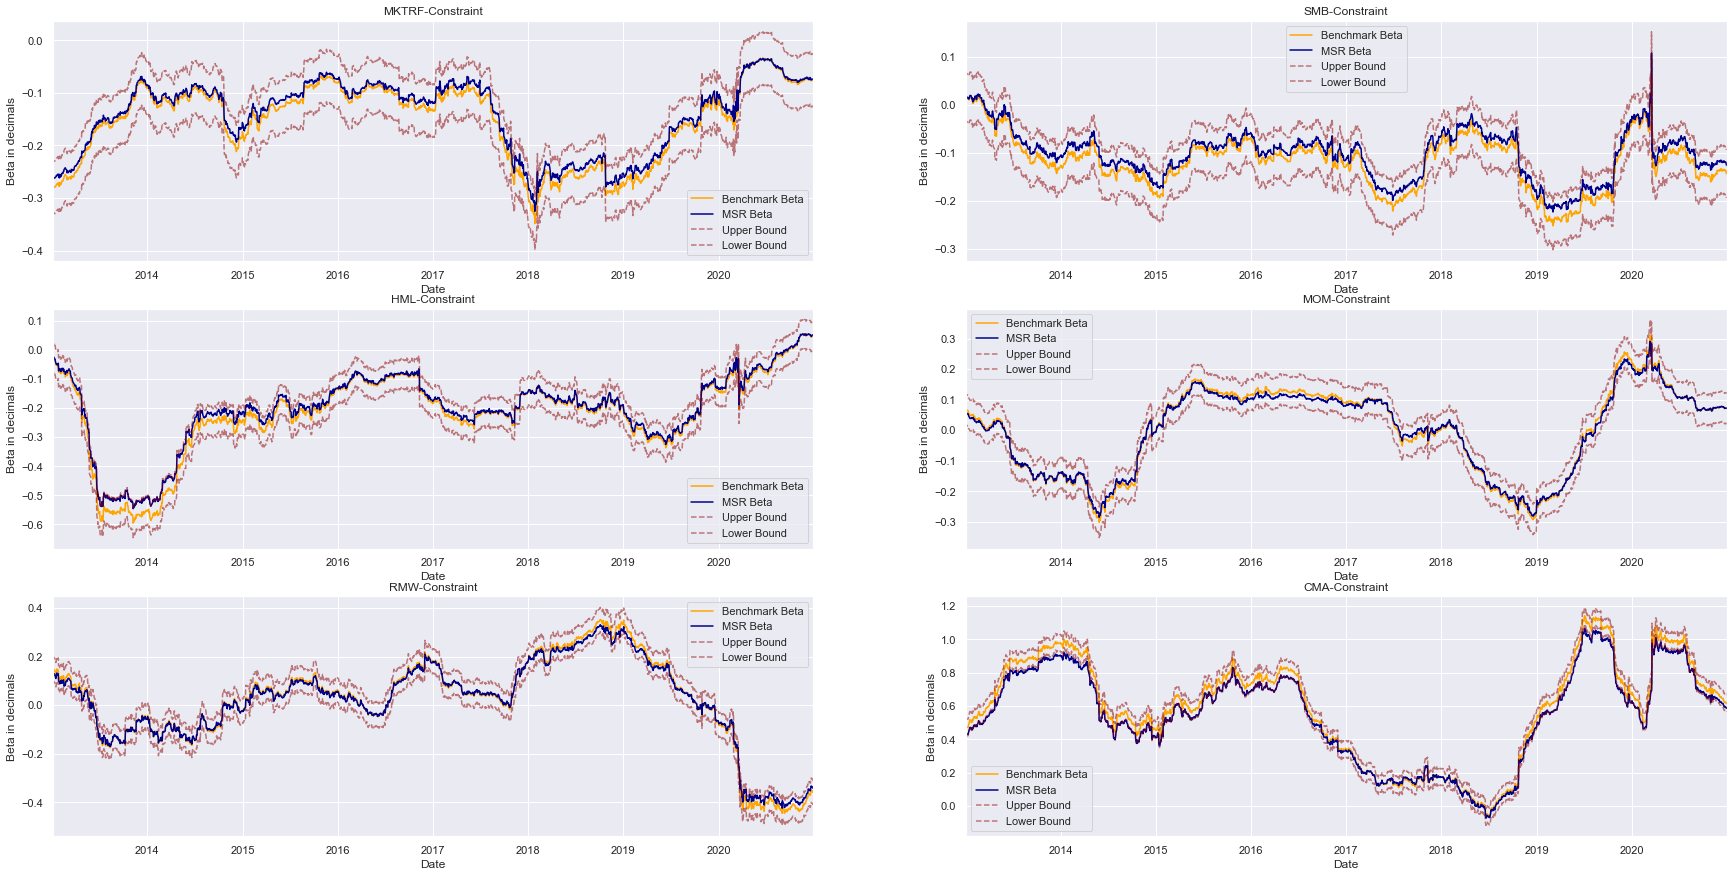

In [78]:
# Plot Beta Constraints

fig = plt.figure(figsize=(30,15))

plt.subplot(3, 2, 1)
plt.plot(bench_mktf_beta.index, bench_mktf_beta.values, color = 'orange', label = 'Benchmark Beta')
plt.plot(mktrf_msr_portfolio.index, mktrf_msr_portfolio.values, color = 'darkblue', label = 'MSR Beta')
plt.plot(bench_mktf_beta_ub.index, bench_mktf_beta_ub.values, '--', color = 'darkred', alpha = 0.5, label = 'Upper Bound')
plt.plot(bench_mktf_beta_lb.index, bench_mktf_beta_lb.values, '--', color = 'darkred', alpha = 0.5, label = 'Lower Bound')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])
plt.title('MKTRF-Constraint')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Beta in decimals')

plt.subplot(3, 2, 2)
plt.plot(bench_smb_beta.index, bench_smb_beta.values, color = 'orange', label = 'Benchmark Beta')
plt.plot(smb_msr_portfolio.index, smb_msr_portfolio.values, color = 'darkblue', label = 'MSR Beta')
plt.plot(bench_smb_beta_ub.index, bench_smb_beta_ub.values, '--', color = 'darkred', alpha = 0.5, label = 'Upper Bound')
plt.plot(bench_smb_beta_lb.index, bench_smb_beta_lb.values, '--', color = 'darkred', alpha = 0.5, label = 'Lower Bound')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])
plt.title('SMB-Constraint')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Beta in decimals')

plt.subplot(3, 2, 3)
plt.plot(bench_hml_beta.index, bench_hml_beta.values, color = 'orange', label = 'Benchmark Beta')
plt.plot(hml_msr_portfolio.index, hml_msr_portfolio.values, color = 'darkblue', label = 'MSR Beta')
plt.plot(bench_hml_beta_ub.index, bench_hml_beta_ub.values, '--', color = 'darkred', alpha = 0.5, label = 'Upper Bound')
plt.plot(bench_hml_beta_lb.index, bench_hml_beta_lb.values, '--', color = 'darkred', alpha = 0.5, label = 'Lower Bound')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])
plt.title('HML-Constraint')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Beta in decimals')

plt.subplot(3, 2, 4)
plt.plot(bench_mom_beta.index, bench_mom_beta.values, color = 'orange', label = 'Benchmark Beta')
plt.plot(mom_msr_portfolio.index, mom_msr_portfolio.values, color = 'darkblue', label = 'MSR Beta')
plt.plot(bench_mom_beta_ub.index, bench_mom_beta_ub.values, '--', color = 'darkred', alpha = 0.5, label = 'Upper Bound')
plt.plot(bench_mom_beta_lb.index, bench_mom_beta_lb.values, '--', color = 'darkred', alpha = 0.5, label = 'Lower Bound')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])
plt.title('MOM-Constraint')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Beta in decimals')

plt.subplot(3, 2, 5)
plt.plot(bench_rmw_beta.index, bench_rmw_beta.values, color = 'orange', label = 'Benchmark Beta')
plt.plot(rmw_msr_portfolio.index, rmw_msr_portfolio.values, color = 'darkblue', label = 'MSR Beta')
plt.plot(bench_rmw_beta_ub.index, bench_rmw_beta_ub.values, '--', color = 'darkred', alpha = 0.5, label = 'Upper Bound')
plt.plot(bench_rmw_beta_lb.index, bench_rmw_beta_lb.values, '--', color = 'darkred', alpha = 0.5, label = 'Lower Bound')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])
plt.title('RMW-Constraint')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Beta in decimals')

plt.subplot(3, 2, 6)
plt.plot(bench_cma_beta.index, bench_cma_beta.values, color = 'orange', label = 'Benchmark Beta')
plt.plot(cma_msr_portfolio.index, cma_msr_portfolio.values, color = 'darkblue', label = 'MSR Beta')
plt.plot(bench_cma_beta_ub.index, bench_cma_beta_ub.values, '--', color = 'darkred', alpha = 0.5, label = 'Upper Bound')
plt.plot(bench_cma_beta_lb.index, bench_cma_beta_lb.values, '--', color = 'darkred', alpha = 0.5, label = 'Lower Bound')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])
plt.title('CMA-Constraint')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Beta in decimals')

plt.show()

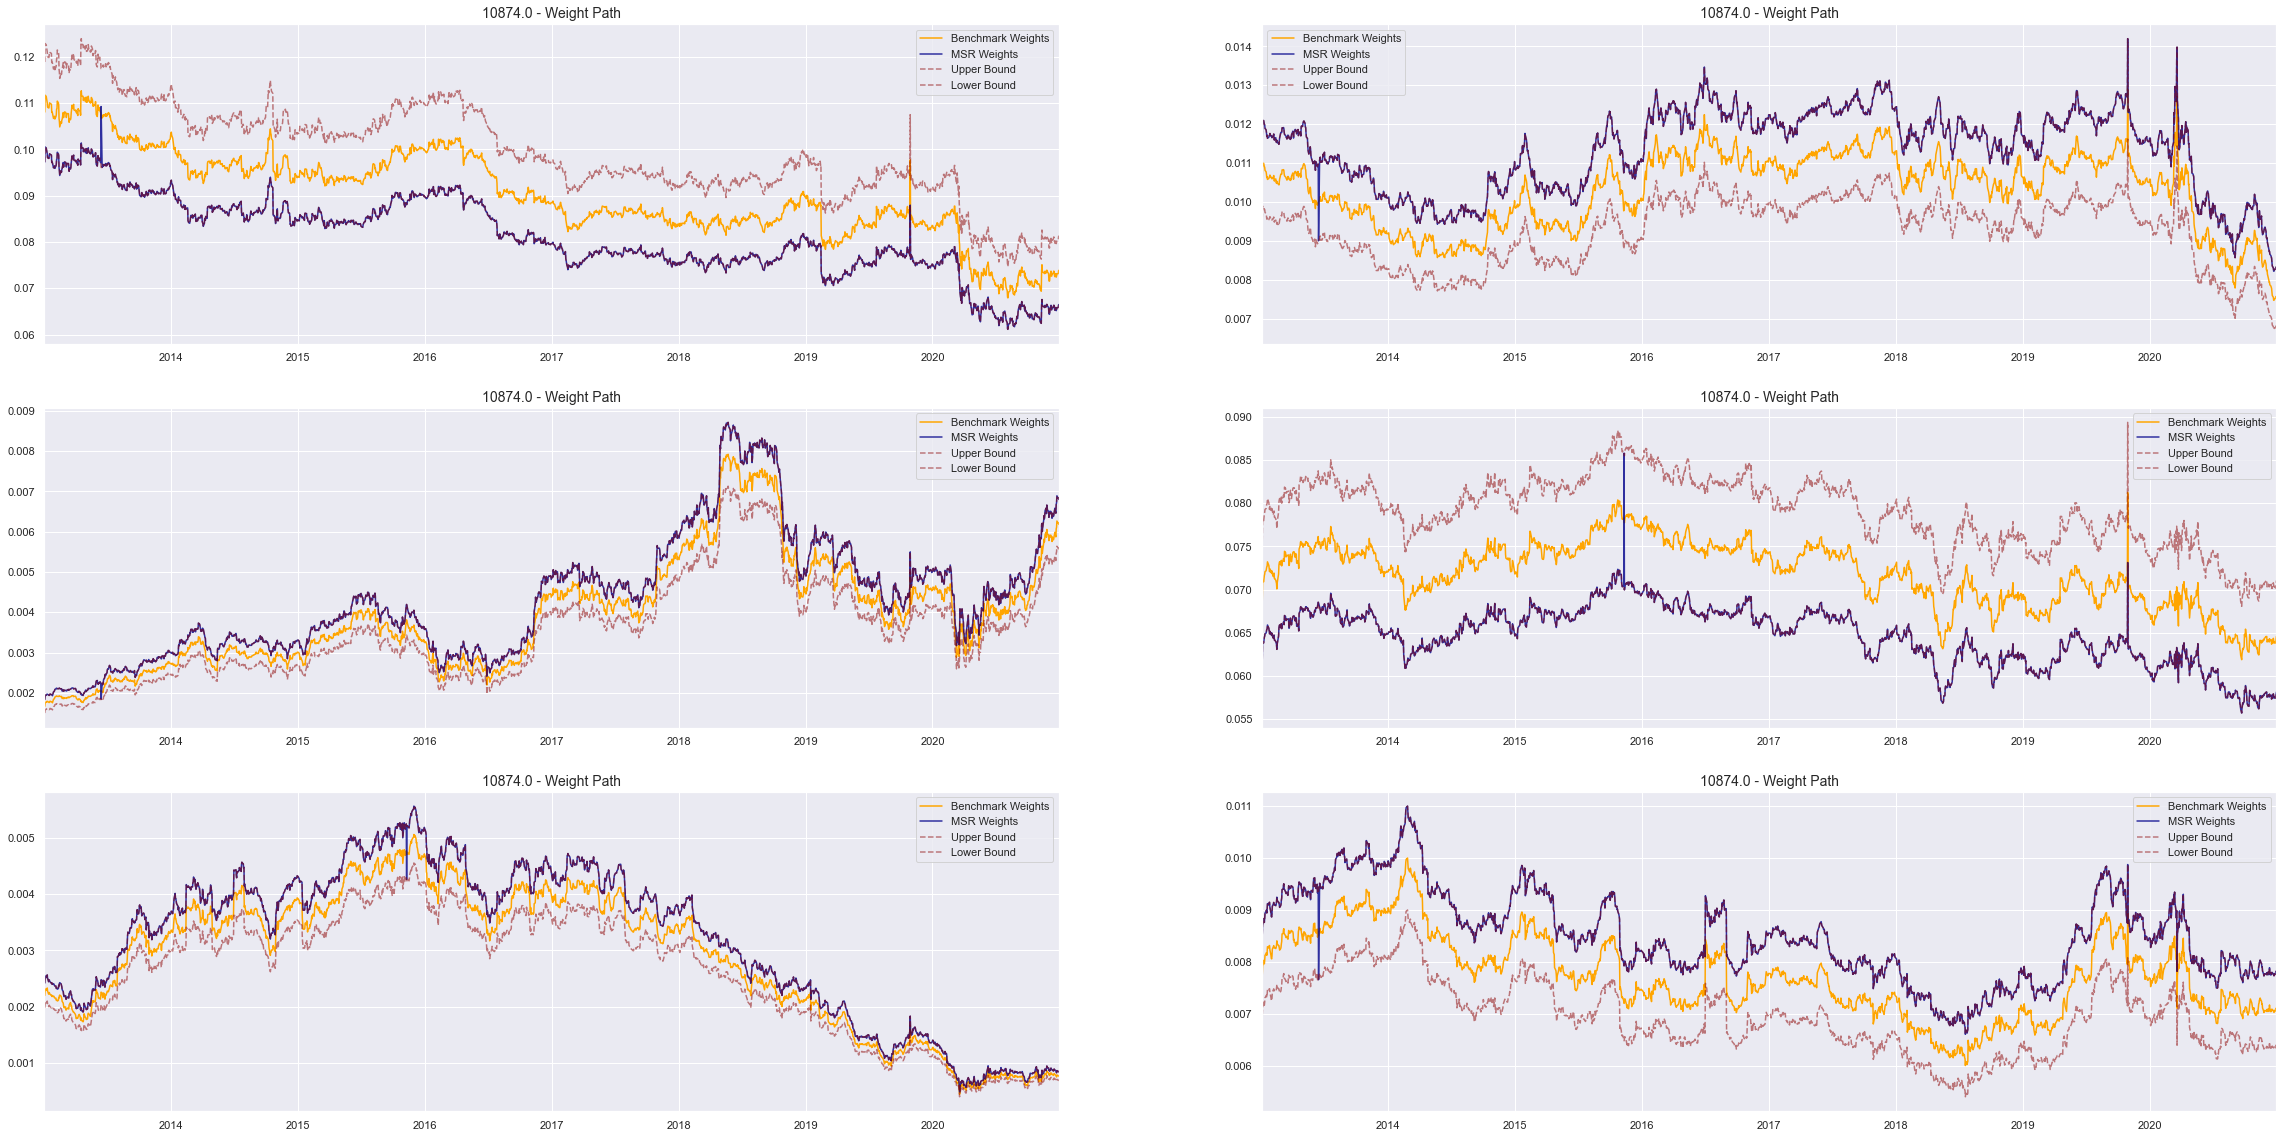

In [79]:
# Plot weight evolution

fig = plt.figure(figsize=(40,20))
for i in range(1, 7):
    plt.subplot(3, 2, i)
    plt.plot(bench_weights[bench_weights.columns[i]].index, bench_weights[bench_weights.columns[i]].values, color = 'orange', label = 'Benchmark Weights')
    plt.plot(msr_portfolio_weights[bench_weights.columns[i]].index, msr_portfolio_weights[bench_weights.columns[i]].values, alpha = 0.8, color = 'darkblue', label = 'MSR Weights')
    plt.plot(bench_weights[bench_weights.columns[i]].index, bench_weights[bench_weights.columns[i]].values * (1 + 0.1),  '--', alpha = 0.5, color = 'darkred', label = 'Upper Bound')
    plt.plot(bench_weights[bench_weights.columns[i]].index, bench_weights[bench_weights.columns[i]].values * (1 - 0.1),  '--', alpha = 0.5, color = 'darkred', label = 'Lower Bound')

    plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])

    plt.title(str(bench_weights.columns[0]) + ' - Weight Path', fontsize = 14)
    plt.legend()
plt.show()

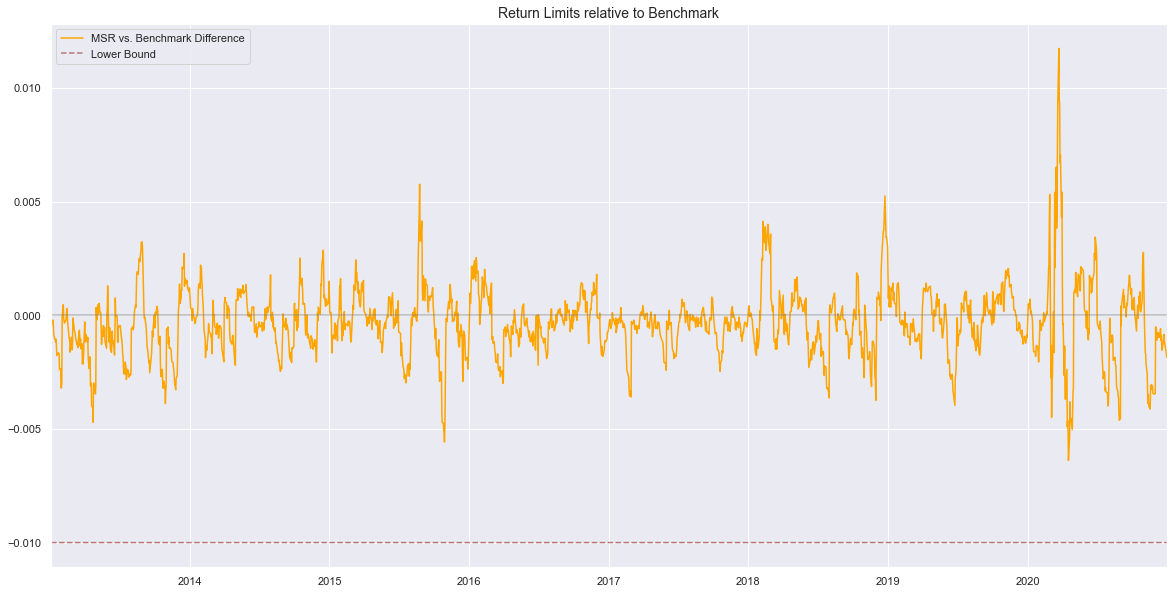

In [80]:
# Plot weight evolution

fig = plt.figure(figsize=(20,10))

plt.plot(dates_rebal, np.array(global_hit_diff), color = 'orange', label = 'MSR vs. Benchmark Difference')
plt.plot(dates_rebal, np.zeros(len(global_hit_diff)) - 0.01,  '--', alpha = 0.5, color = 'darkred', label = 'Lower Bound')
plt.axhline(0, color = 'grey', alpha = 0.5)

plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])

plt.title('Return Limits relative to Benchmark', fontsize = 14)
plt.legend()
plt.show()

In [81]:
bench_weighted_returns = actual_returns * bench_weights
bench_weighted_returns.dropna
bench_weighted_returns = bench_returns.sum(axis = 1)
bench_weighted_cum_returns = np.cumprod(1 + bench_weighted_returns)

In [82]:
msr_weighted_returns = actual_returns * msr_portfolio_weights
msr_weighted_returns.dropna
msr_weighted_returns = msr_weighted_returns.sum(axis = 1)
msr_weighted_cum_returns = np.cumprod(1 + msr_weighted_returns)

In [83]:
actual_returns

permno,"10,874.00","11,308.00","11,404.00","11,786.00","13,856.00","16,432.00","16,600.00","17,144.00","17,750.00","18,163.00",...,"75,341.00","76,644.00","77,649.00","80,539.00","82,598.00","83,601.00","84,519.00","85,663.00","86,102.00","88,664.00"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.01,0.00,-0.00,0.01,0.00,0.00,-0.01,0.00,-0.00,-0.01,...,0.01,-0.02,0.00,0.03,-0.00,-0.00,-0.02,0.00,0.02,0.00
2013-01-04,-0.00,0.00,0.01,0.02,0.00,0.02,0.01,0.01,0.00,0.00,...,0.01,0.01,0.01,0.01,-0.00,0.01,-0.01,0.02,0.05,0.00
2013-01-07,-0.01,-0.01,-0.01,-0.01,-0.00,-0.02,-0.00,-0.00,-0.02,-0.01,...,0.01,0.00,0.01,-0.01,-0.02,0.02,-0.00,-0.02,-0.03,0.00
2013-01-08,-0.01,-0.01,-0.01,0.01,0.00,-0.00,-0.01,0.00,-0.01,-0.00,...,0.00,-0.03,-0.01,-0.01,-0.02,-0.01,-0.04,-0.00,-0.01,-0.00
2013-01-09,0.02,-0.00,0.00,0.00,0.01,0.02,0.01,-0.00,0.01,0.01,...,0.01,0.02,0.02,0.08,-0.01,0.02,-0.02,0.00,-0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,-0.01,0.01,0.01,0.03,0.00,0.05,0.01,0.01,0.01,-0.00,...,-0.02,-0.00,0.01,-0.01,-0.00,0.01,0.01,0.02,-0.01,0.01
2020-12-24,-0.01,0.01,0.01,-0.00,0.00,-0.01,0.00,0.00,0.00,0.01,...,0.01,-0.00,0.01,-0.00,-0.01,0.02,0.01,0.01,0.00,0.01
2020-12-28,-0.01,0.01,0.01,0.01,0.01,-0.00,0.01,0.00,0.00,0.01,...,0.01,-0.03,-0.00,0.01,0.00,-0.00,0.00,-0.02,-0.00,0.01


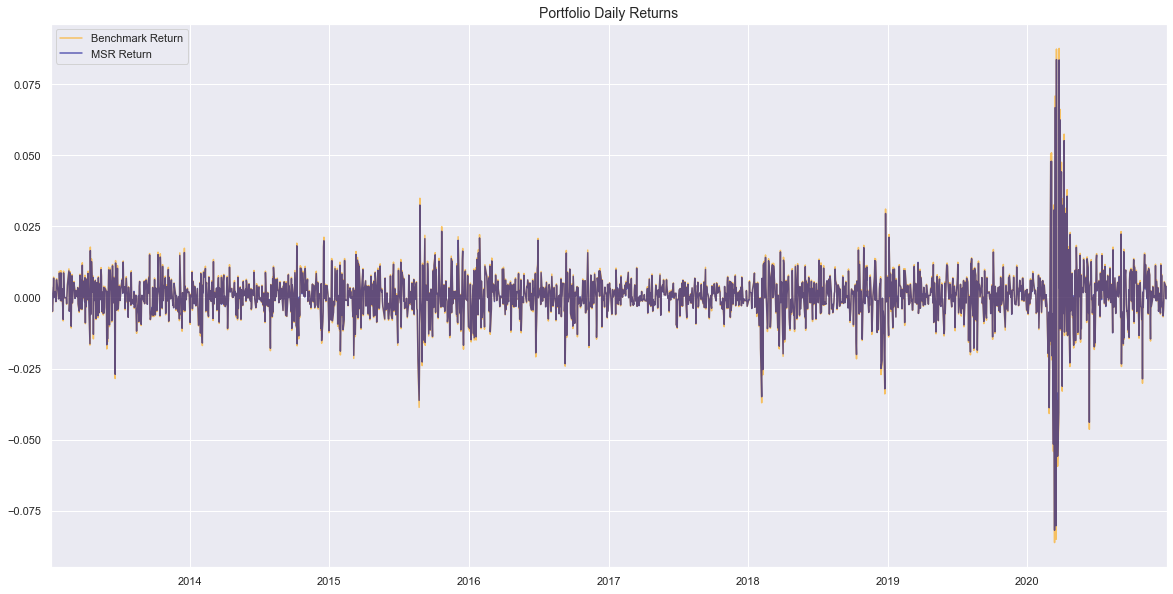

In [84]:
# Plot Daily Returns

fig = plt.figure(figsize=(20,10))

plt.plot(bench_weighted_returns.index, bench_weighted_returns.values, alpha = 0.6, color = 'orange', label = 'Benchmark Return')
plt.plot(msr_weighted_returns.index, msr_weighted_returns.values,  alpha = 0.6, color = 'darkblue', label = 'MSR Return')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])

plt.title('Portfolio Daily Returns', fontsize = 14)
plt.legend()
plt.show()

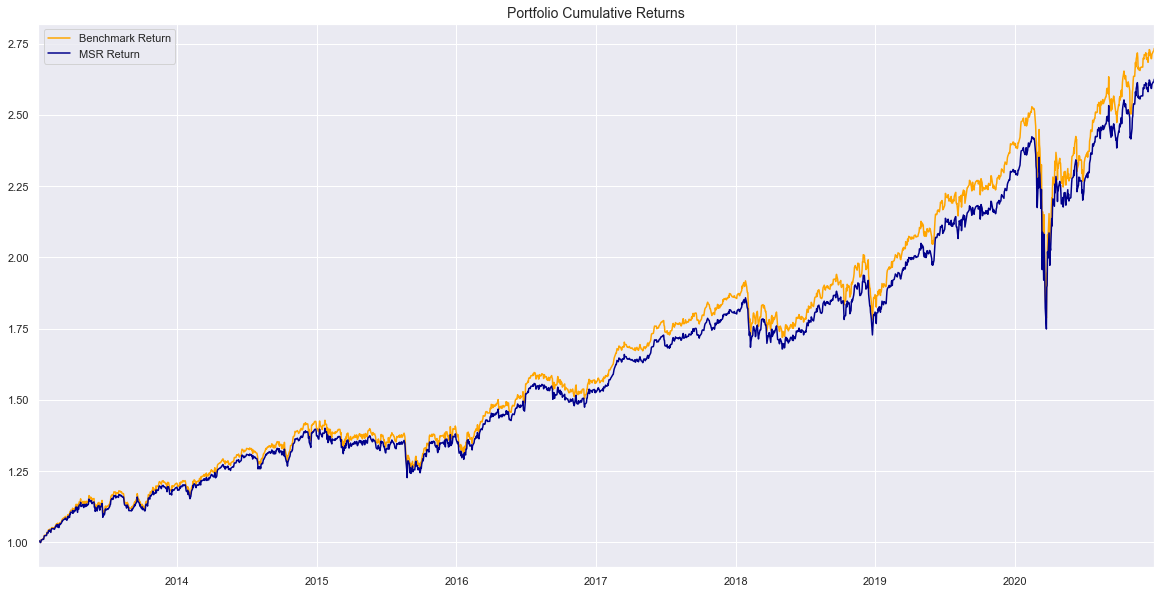

In [85]:
# Plot Cumulative Returns

fig = plt.figure(figsize=(20,10))

plt.plot(bench_weighted_cum_returns.index, bench_weighted_cum_returns.values, color = 'orange', label = 'Benchmark Return')
# plt.plot(bench_lb_weighted_cum_returns.index, bench_lb_weighted_cum_returns.values,  '--', alpha = 0.5, color = 'darkred', label = 'Lower Bound')
plt.plot(msr_weighted_cum_returns.index, msr_weighted_cum_returns.values, color = 'darkblue', label = 'MSR Return')
plt.xlim([datetime.datetime(2013,1,2), datetime.datetime(2020,12,30)])

plt.title('Portfolio Cumulative Returns', fontsize = 14)
plt.legend()
plt.show()

                    Strategy
------------------  ----------
Start Period        2013-01-03
End Period          2020-12-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   173.29%
CAGR﹪              13.4%

Sharpe              0.92
Sortino             1.33
Sortino/√2          0.94
Omega               1.21

Max Drawdown        -29.32%
Longest DD Days     411

Gain/Pain Ratio     0.21
Gain/Pain (1M)      1.62

Payoff Ratio        0.97
Profit Factor       1.21
Common Sense Ratio  1.15
CPC Index           0.65
Tail Ratio          0.95
Outlier Win Ratio   3.75
Outlier Loss Ratio  4.12

MTD                 2.47%
3M                  7.78%
6M                  18.9%
YTD                 13.85%
1Y                  14.18%
3Y (ann.)           13.73%
5Y (ann.)           14.55%
10Y (ann.)          13.4%
All-time (ann.)     13.4%

Avg. Drawdown       -1.52%
Avg. Drawdown Days  17
Recovery Factor     5.91
Ulcer Index         0.04
Serenity Index      5.19


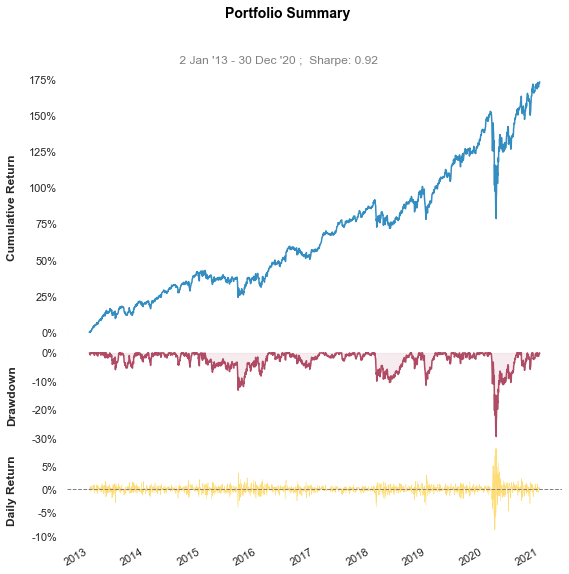

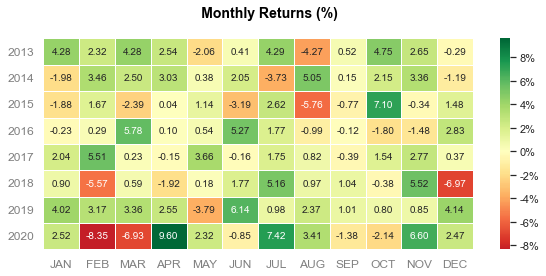

In [86]:
qs.reports.basic(bench_weighted_returns)

                    Strategy
------------------  ----------
Start Period        2013-01-03
End Period          2020-12-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   162.46%
CAGR﹪              12.83%

Sharpe              0.93
Sortino             1.34
Sortino/√2          0.95
Omega               1.21

Max Drawdown        -27.84%
Longest DD Days     411

Gain/Pain Ratio     0.21
Gain/Pain (1M)      1.64

Payoff Ratio        0.96
Profit Factor       1.21
Common Sense Ratio  1.15
CPC Index           0.65
Tail Ratio          0.95
Outlier Win Ratio   3.74
Outlier Loss Ratio  4.16

MTD                 2.28%
3M                  7.49%
6M                  17.71%
YTD                 13.9%
1Y                  14.22%
3Y (ann.)           13.33%
5Y (ann.)           14.06%
10Y (ann.)          12.83%
All-time (ann.)     12.83%

Avg. Drawdown       -1.45%
Avg. Drawdown Days  17
Recovery Factor     5.84
Ulcer Index         0.04
Serenity Index      5.28


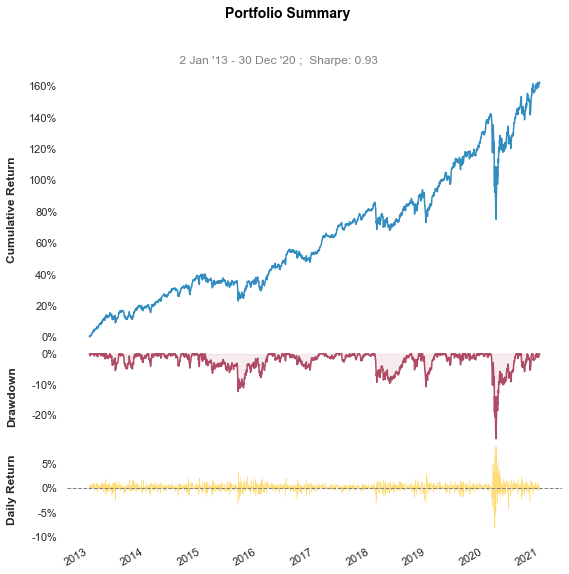

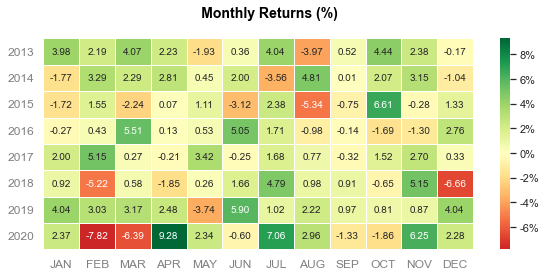

In [87]:
qs.reports.basic(msr_weighted_returns)